In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#Adapted from: 
# lqr_neural_error_dynamics.ipynb

import scipy.io as sio
import scipy.stats as sio_stat
import scipy.interpolate
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt 

import os
import pickle
import sys
import copy

import time
import pylab as pl
from IPython import display

from bmi_dynamics_code import behavior_co_obs as bmi_b
from bmi_dynamics_code import data_for_v as preeyacode
from bmi_dynamics_code import util as bmi_util
from bmi_dynamics_code import analyze_lqr

import timeit
from sklearn import decomposition as skl_decomp

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

%matplotlib notebook

In [3]:
%matplotlib notebook

In [4]:
#Load a base file for simulation parameters: 
ext_list =['.png', '.eps']

plot_dir = r'D:\Dropbox\BMI_co_obs_paper\data\vivek\lqr'

home_dir = r'D:\Dropbox\Code\preeya_co_obstacle'
data_dir = r'D:\Dropbox\Data\preeya_co_obstacle'
data_path = os.path.join(data_dir, 'for_v_df.pkl')
print(os.path.exists(data_path))
d = pickle.load(open(data_path))

#UNPACK: 
decoder = d['decoder']
pre = d['pre']
num_targets = d['num_targets']
sample_period = d['sample_period']
target_hold_time = d['target_hold_time']
num_neurons = d['num_neurons']
target_color = d['target_color']
obs_big = d['obs_big']
obs_small = d['obs_small']
target_r_task = d['target_r_task'] #target_r_task = {0:1.7, 1:2.0}
cursor_r = d['cursor_r']
target_r_eff = d['target_r_eff']
target_pos = d['target_pos']
target_angle = np.arctan2(target_pos[:,1], target_pos[:,0])
target_dist = np.linalg.norm(target_pos, axis=1)
obs_pos = d['obs_pos']

tc_meta = d['tc_meta']
task_list = d['task_list']
num_tasks = len(task_list)
task2idx = d['task2idx']
idx2task = bmi_util.invert_dic(task2idx)
task2tc = d['task2tc']
tc_list = d['tc_list']
df = d['df']
df_label = d['df_label']

task_color = ['k', 'r']

#Pre-processing: 

bmi_b.preprocess_bmi_df(df, target_pos, pre, num_tasks, num_targets)
num_cw = 2
cw_label = ['cw', 'ccw']
task_rot_list = [0,1.1,1.2]

#Binning: 
#MAGNITUDE:
num_mag_bins = 5
num_mag_bins_analyze = 4
# mag_bin_perc = np.array([0,25,50,75,100])
mag_bin_perc = np.concatenate([np.linspace(0,95,5),np.array([100])])
#ANGLE:
num_angle_bins = 8
T0_angle = -3*(2*np.pi)/8
mag_bin, mag_bin_edges, mag_bin_c, angle_bin_c, angle_bin, angle_bin_edges =\
bmi_b.def_command_bin(df, mag_bin_perc, num_angle_bins, T0_angle)
#CENTER ANGLE DATA FOR BINNING (based on bin boundaries): 
angle_center_for_binning = bmi_b.df_center_angle_for_binning(df, angle_bin)
#BIN: 
bmi_b.df_bin_command(df, mag_bin_edges,angle_bin_edges)

#Pre-processing continued:

#Center angles to command bin, target: 
bmi_b.center_df_angle(df, angle_bin_c, target_angle)

True
('angle_center:', 22.5)
('min centered angle:', -157.47162455426732)
('max centered angle:', 202.46708261619673)


<IPython.core.display.Javascript object>


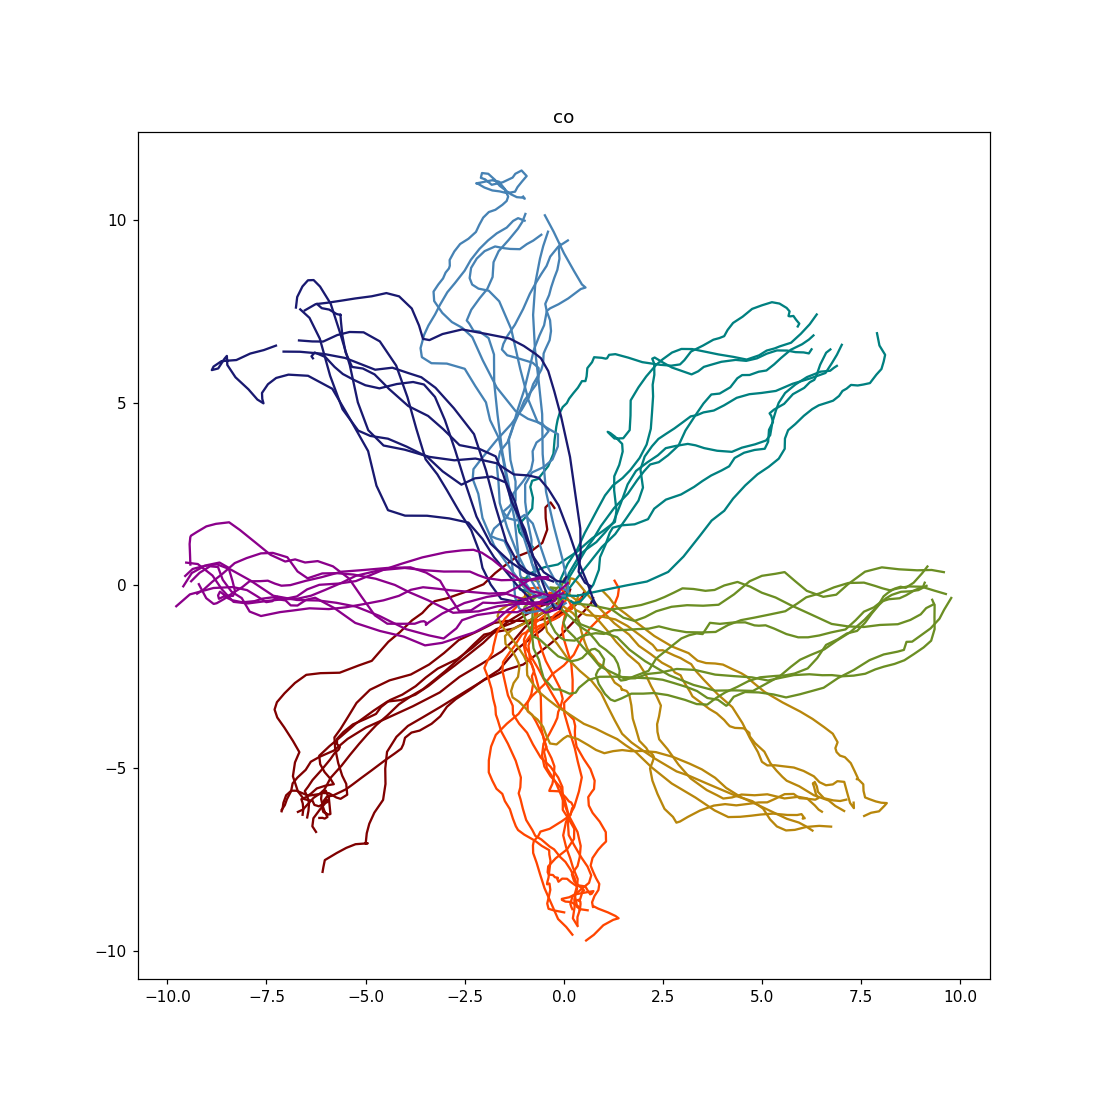

<IPython.core.display.Javascript object>


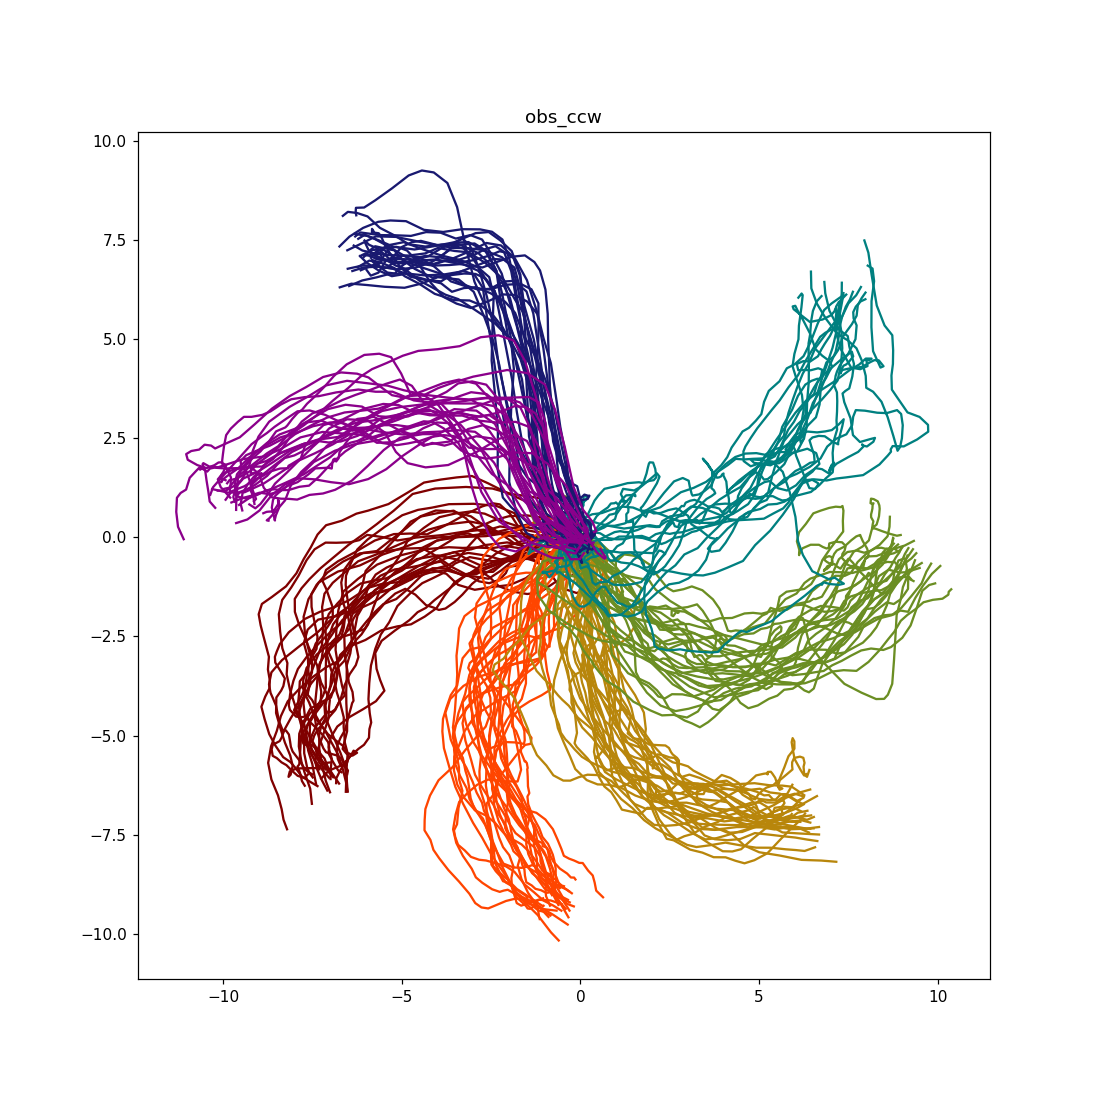

<IPython.core.display.Javascript object>


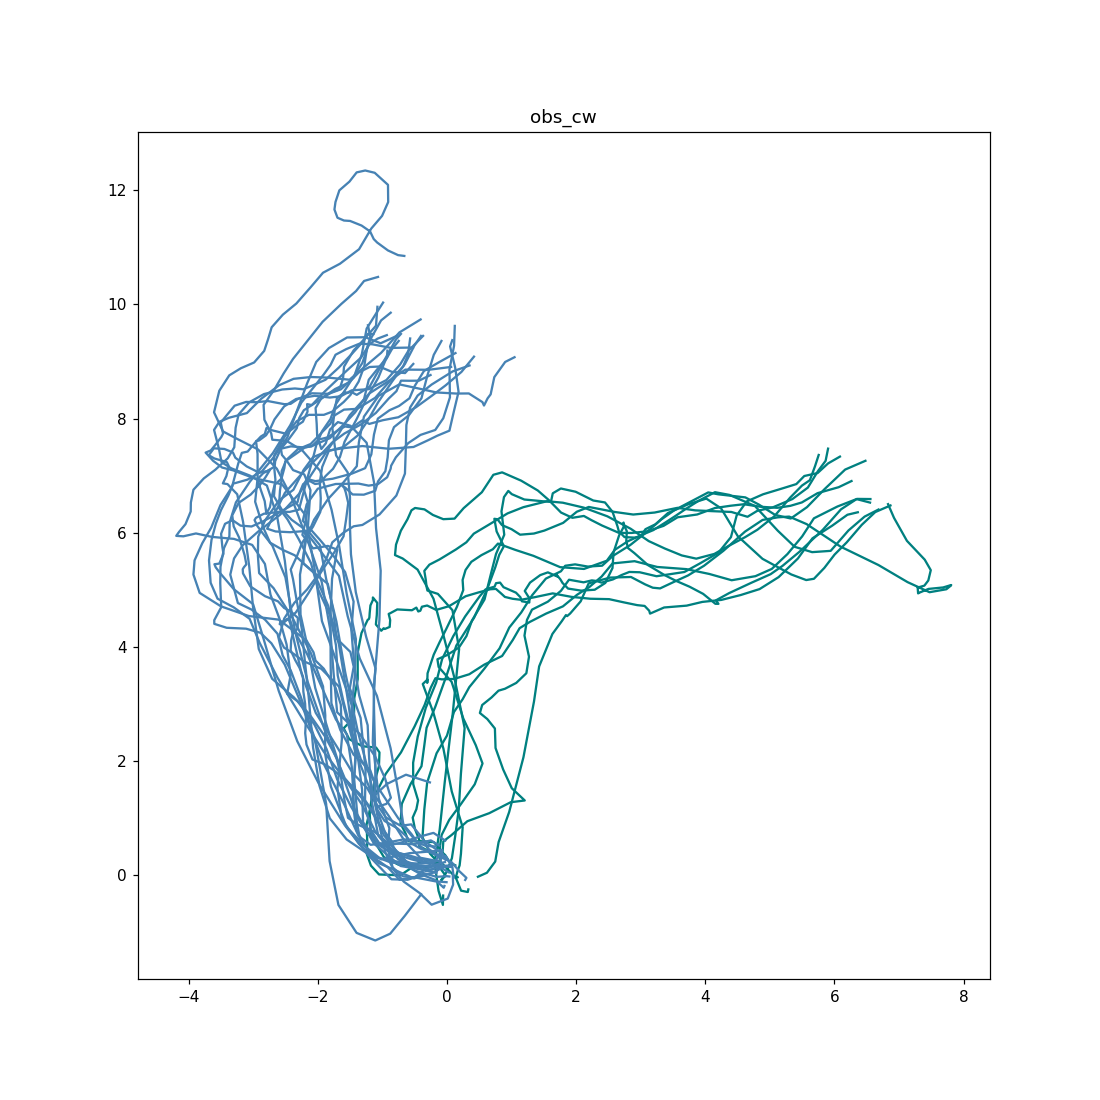

In [5]:
#Plot cw vs ccw trials, to confirm: 
plot = {}
plot['size'] = (10,10)
plot['xlim'] = (-12.5,12.5)
plot['ylim'] = (-12.5,12.5)
task_rot_list = [0,1.1,1.2]
task_rot_label = ['co','obs_ccw', 'obs_cw']

for i,task in enumerate(task_rot_list):
    plt.figure(figsize=plot['size'])
    plt.title(task_rot_label[i])
    for target in range(num_targets):    
            sel = (df['task_rot']==task) & (df['bin']>=0) & (df['target']==target)
            df_sel = df[sel]
            #------------------------------------------------------------------------------------
            #TRIALS: 
            trial_start = np.where(df_sel['bin']==0)[0]
            trial_stop = np.where(df_sel['bin_end']==0)[0]
            trial_bound = np.vstack((trial_start,trial_stop)).T
            #------------------------------------------------------------------------------------
            for bnd in trial_bound[:,:]: #trial_bound[0:1,:]:
    #             if (task_str == 'co') or (task_str == 'obs') and (df_sel['obs_size'][bnd[0]:bnd[0]+1] == obs_big).bool(): 
                x = df_sel['kin_px'][bnd[0]:bnd[1]+1]
                y = df_sel['kin_py'][bnd[0]:bnd[1]+1]
                color = target_color[target]
                plt.plot(x,y,'-',color=color)

In [6]:
a_list = ['grom', 'jeev']
a2num_days = {'grom':9, 'jeev':4}

In [ ]:
#Pool simulations from "full dynamics" and "decoder_null dynamics" 
#Original simulation: 'lqr_sim_20trials.pkl', 'lqr_sim_20trials_decoder_null_dyn.pkl'
#10/27/2022 simulation: 'lqr_sim_Q2_full.pkl', 'lqr_sim_Q2_decoder_null.pkl'

In [7]:
#Dynamics models: 
dm_list = ['full', 'decoder_null'] #dynamics, decoder_null dynamics
num_trials = 20 #number of trials simulated with lqr
# dm_files = {dm_list[0]:'lqr_sim_'+str(num_trials)+'trials.pkl',\
#             dm_list[1]:'lqr_sim_'+str(num_trials)+'trials_decoder_null_dyn.pkl'}

# dm_files = {dm_list[0]:'lqr_sim_Q2_full.pkl',\
#             dm_list[1]:'lqr_sim_Q2_decoder_null.pkl'}


dm_files = {dm_list[0]:'lqr_init_fp_full_noisy.pkl',\
            dm_list[1]:'lqr_init_fp_20_decoder_null_enf_noisy.pkl'}
#'lqr_init_fp_decoder_null_noisy.pkl'

In [8]:
model_list_analyze = \
[('full', 'n_do'), \
 ('decoder_null', 'n_do'), \
 ('full', 'n_o'), \
 ('decoder_null', 'n_o')]

mla = model_list_analyze

model_pairs = []
pair = (mla[0], mla[1])
model_pairs.append(pair)

pair = (mla[0], mla[2])
model_pairs.append(pair)

pair = (mla[1], mla[2])
model_pairs.append(pair)

pair = (mla[1], mla[3])
model_pairs.append(pair)


In [ ]:
# #Load an example lqr sim
# a = 'grom'
# d = 0
# load_dir = os.path.join(save_home, a, str(d))
# sim_dm_paths = {}
# for dm in dm_list:
#     sim_dm_paths[dm] = os.path.join(load_dir, dm_files[dm])
# lqr_dm, df_pool = analyze_lqr.pool_lqr_sim_across_dm(dm_list, sim_dm_paths)  


In [9]:
#Information for analysis: 
save_home = r'D:\DATA\bmi_co_obs_backup'

#analyze neural diff: 
p_sig_match = 0.05 #0.5
shuffle_bool = True
num_shuffle = 10
min_obs = 15

#Save information
save_file = \
'analysis_v2.1_lqr_full_vs_decoder_null_'+str(num_trials)+'trials_'+ str(num_shuffle) + 'shuffles' +'.pkl'
# save_file = \
# 'curr_test' +'.pkl'
print(save_file)
#v2 refers to fixing how pooling data for the shuffle is done

analysis_v2.1_lqr_full_vs_decoder_null_20trials_10shuffles.pkl


In [10]:
move_list, c_list, n_list = \
        analyze_lqr.def_var_lists(num_targets, task_rot_list, num_mag_bins_analyze, num_angle_bins, num_neurons)

In [ ]:
#model_list_analyze = [('decoder_null', 'n_o')]

# [('full', 'n_do'),
#  ('decoder_null', 'n_do'),
#  ('full', 'n_o'),
#  ('decoder_null', 'n_o')]

In [ ]:
#Run analysis:
debug_bool = False
for a in a_list: #[a_list[0]]: #a_list:
    for d in range(a2num_days[a]): #[0]: #range(a2num_days[a]):
        t_iter_start = timeit.default_timer()
        print(a,d)
        load_dir = os.path.join(save_home, a, str(d))
        
#         if not debug_bool:
            #lqr sim paths for dynamics models (dm):
        sim_dm_paths = {}
        for dm in dm_list:
            sim_dm_paths[dm] = os.path.join(load_dir, dm_files[dm])
        lqr_dm, df_pool = analyze_lqr.pool_lqr_sim_across_dm(dm_list, sim_dm_paths)

        #Load some params, must be the same across dynamics models: 
        target_list = lqr_dm[dm_list[0]]['target_list'] 
        task_rot_list = lqr_dm[dm_list[0]]['task_rot_list'] 
        num_neurons = lqr_dm[dm_list[0]]['num_neurons']
        #Decoder:
        Kn = lqr_dm[dm_list[0]]['Kn']
        
        #labels for movements, commands, neurons:
        move_list, c_list, n_list = \
        analyze_lqr.def_var_lists(num_targets, task_rot_list, num_mag_bins_analyze, num_angle_bins, num_neurons)
        #If debug, analyze small subsets of data:
        if debug_bool:
            move_list = move_list[0:2]
            c_list = [(3,0)] #[c_list[1]]
        
        #analyze u norm:
        r_u = \
        analyze_lqr.analyze_u_norm(lqr_dm, model_list_analyze, model_pairs, target_list, task_rot_list)
        
        #Analyze the difference in neural activity for (command,movement) from the movement-pooled neural activity
        model_cm =  \
        analyze_lqr.main_compute_neural_command_diff(df_pool['df_lqr_n'], Kn, model_list_analyze, move_list, c_list, n_list, p_sig_match, shuffle_bool, num_shuffle)
        model_diff = analyze_lqr.collect_neural_command_diff(model_cm, Kn, model_list_analyze, c_list, move_list, min_obs)
        
        r_n = analyze_lqr.analyze_n_diff(model_diff, model_list_analyze, model_pairs)
        
        #Save results: 
        r = {}
        r['Kn'] = Kn
        r['num_targets'] = num_targets
        r['task_rot_list'] = task_rot_list
        r['num_mag_bins_analyze'] = num_mag_bins_analyze
        r['num_angle_bins'] = num_angle_bins
        r['num_neurons'] = num_neurons
        r['m_list'] = move_list
        r['c_list'] = c_list
        r['n_list'] = n_list
        r['p_sig_match'] = p_sig_match
        r['shuffle_bool'] = shuffle_bool
        r['num_shuffle'] = num_shuffle
        r['min_obs'] = min_obs
        r['model_cm'] = model_cm
        r['model_diff'] = model_diff
        r['norm_u_df_n'] = df_pool['norm_u_df_n']
        r['r_u'] = r_u
        r['r_n'] = r_n
        
        save_dir = os.path.join(save_home, a, str(d))
        save_path = os.path.join(save_dir, save_file)
        print(save_path)
        with open(save_path, 'wb') as f: 
            data = pickle.dump(r, f, protocol=pickle.HIGHEST_PROTOCOL)    
            
        t_iter_elapsed = timeit.default_timer()-t_iter_start
        print('time iteration: ' + str(t_iter_elapsed))
        print('DONE!')        
        
        

In [ ]:
lqr_dm.keys()

In [ ]:
for m in model_list_analyze:
    print(m)
    print(r_u[m])
    print('')

In [ ]:
model_pairs

In [ ]:
for pair in model_pairs:
    print(pair)
    print(r_u[pair, 'wilcoxon'])
    print('')

In [ ]:
r_n.keys()

### Inspect matched-pool

In [ ]:
m = model_list_analyze[0]
m

In [ ]:
c = c_list[0]
mv = move_list[1]
print(c, mv)

In [ ]:
m

In [ ]:
model_cm[m, c, mv, 'cm_idx']

In [ ]:
model_cm[m, c, 'c_idx']

In [ ]:
model_cm[m, c, mv, 'pool_match_idx']

In [ ]:
for i in model_cm[m, c, mv, 'cm_idx']:
    if i not in model_cm[m, c, mv, 'pool_match_idx']:
        print('absent:', i)
    else:
        print(i)
        

In [ ]:
df_pool.keys()

In [ ]:
df_pool['df_lqr_n'].keys()

In [ ]:
df_pool['df_lqr_n'].head()

In [ ]:
list(df_pool['df_lqr_n'].columns)

In [ ]:
c_idx

In [ ]:
model_cm[m, c, mv, 'pool_match_idx']

In [ ]:
c_idx = model_cm[m, c, 'c_idx']
cm_idx = model_cm[m, c, mv, 'cm_idx']
pool_idx = model_cm[m, c, mv, 'pool_match_idx']
#df_pool['df_lqr_n'].loc[c_idx][['dynamics', 'model', 'u_vx', 'u_vy', 'u_v_mag_bin', 'u_v_angle_bin']]
d_c = df_pool['df_lqr_n'].loc[c_idx][['u_vx', 'u_vy']]
d_cm = df_pool['df_lqr_n'].loc[cm_idx][['u_vx', 'u_vy']]
d_pool = df_pool['df_lqr_n'].loc[pool_idx][['u_vx', 'u_vy']]


In [ ]:
plt.figure(figsize=(7,7))
plt.scatter(d_c['u_vx'], d_c['u_vy'], alpha=0.5,s=20)
plt.scatter(d_pool['u_vx'], d_pool['u_vy'], alpha=0.5,s=10)
plt.scatter(d_cm['u_vx'], d_cm['u_vy'], alpha=0.5,s=1, color='r')

plt.axis('square')

### Load all session's results

In [11]:
#Information for analysis: 
save_home = r'D:\DATA\bmi_co_obs_backup'

#analyze neural diff: 
p_sig_match = 0.05
shuffle_bool = True
num_shuffle = 1000 #10 #1000
min_obs = 15
num_trials = 20

#Save information
save_file = \
'analysis_v2.1_lqr_full_vs_decoder_null_'+str(num_trials)+'trials_'+ str(num_shuffle) + 'shuffles' +'.pkl'
#'analysis_v2_lqr_full_vs_decoder_null_'+str(num_trials)+'trials_'+ str(num_shuffle) + 'shuffles' +'.pkl'
#'analysis_lqr_full_vs_decoder_null_'+str(num_trials)+'trials_'+ str(num_shuffle) + 'shuffles' +'.pkl'
print(save_file)

analysis_v2.1_lqr_full_vs_decoder_null_20trials_1000shuffles.pkl


In [12]:
#Load all session's results
load_file = save_file

r_pool = {}
for a in a_list: 
    for d in range(a2num_days[a]):
        print(a,d)
        load_dir = os.path.join(save_home, a, str(d))
#         print(os.path.exists(load_dir))
#         load_file = 'analysis_lqr_sim_20trials.pkl'
        load_path = os.path.join(load_dir, load_file)
        print(load_path)
        with open(load_path, 'rb') as f: 
            r = pickle.load(f)     
        r_pool[(a,d)] = r
#         del r_pool[(a,d)]['model_cm']
        
        

('grom', 0)
D:\DATA\bmi_co_obs_backup\grom\0\analysis_v2.1_lqr_full_vs_decoder_null_20trials_1000shuffles.pkl
('grom', 1)
D:\DATA\bmi_co_obs_backup\grom\1\analysis_v2.1_lqr_full_vs_decoder_null_20trials_1000shuffles.pkl
('grom', 2)
D:\DATA\bmi_co_obs_backup\grom\2\analysis_v2.1_lqr_full_vs_decoder_null_20trials_1000shuffles.pkl
('grom', 3)
D:\DATA\bmi_co_obs_backup\grom\3\analysis_v2.1_lqr_full_vs_decoder_null_20trials_1000shuffles.pkl
('grom', 4)
D:\DATA\bmi_co_obs_backup\grom\4\analysis_v2.1_lqr_full_vs_decoder_null_20trials_1000shuffles.pkl
('grom', 5)
D:\DATA\bmi_co_obs_backup\grom\5\analysis_v2.1_lqr_full_vs_decoder_null_20trials_1000shuffles.pkl
('grom', 6)
D:\DATA\bmi_co_obs_backup\grom\6\analysis_v2.1_lqr_full_vs_decoder_null_20trials_1000shuffles.pkl
('grom', 7)
D:\DATA\bmi_co_obs_backup\grom\7\analysis_v2.1_lqr_full_vs_decoder_null_20trials_1000shuffles.pkl
('grom', 8)
D:\DATA\bmi_co_obs_backup\grom\8\analysis_v2.1_lqr_full_vs_decoder_null_20trials_1000shuffles.pkl
('jeev', 0

In [ ]:
r.keys()

### inspect loaded data

In [ ]:
move_list

In [ ]:
lqr_dm['decoder_null']['move_lqr_n'].keys()

In [ ]:
lqr_dm['decoder_null']
df_pool['df_lqr_n'].head()

In [ ]:
r_pool[a,d].keys()

In [ ]:
a = 'grom'
d = 0
# model = ('full', 'n_do')
model = ('decoder_null', 'n_do')
proj = 'full'

In [ ]:
c = c_list[0]
m = move_list[0]
print(c,m)

In [37]:
move_list

[(0, 0),
 (0, 1.1),
 (0, 1.2),
 (1, 0),
 (1, 1.1),
 (1, 1.2),
 (2, 0),
 (2, 1.1),
 (2, 1.2),
 (3, 0),
 (3, 1.1),
 (3, 1.2),
 (4, 0),
 (4, 1.1),
 (4, 1.2),
 (5, 0),
 (5, 1.1),
 (5, 1.2),
 (6, 0),
 (6, 1.1),
 (6, 1.2),
 (7, 0),
 (7, 1.1),
 (7, 1.2)]

In [36]:
c_list

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (0, 6),
 (0, 7),
 (1, 0),
 (1, 1),
 (1, 2),
 (1, 3),
 (1, 4),
 (1, 5),
 (1, 6),
 (1, 7),
 (2, 0),
 (2, 1),
 (2, 2),
 (2, 3),
 (2, 4),
 (2, 5),
 (2, 6),
 (2, 7),
 (3, 0),
 (3, 1),
 (3, 2),
 (3, 3),
 (3, 4),
 (3, 5),
 (3, 6),
 (3, 7)]

In [ ]:
r_pool[(a,d)]['model_cm'][model,c,m,'n_diff_norm', 'obs', proj]

In [ ]:
r_pool[(a,d)]['model_cm'][model,c,m,'n_diff_norm', 's', proj]

In [ ]:
r_pool[(a,d)]['model_cm'][model,c,m,'n_diff_norm_mean', 's', proj]

In [ ]:
r_pool[(a,d)]['model_cm'][(model, c, m, 'n_s')].shape

In [ ]:
r_pool[(a,d)]['model_cm'][(model, c, m, 'n_s')]

In [ ]:
len(r_pool[(a,d)]['model_cm'][model,c,m,'pool_match_idx'])

In [ ]:

for proj in ['potent', 'null']:
    print(proj)
    print('')
    for model in [('decoder_null', 'n_do'), ('decoder_null', 'n_o')]:
        print(model)
        print('  obs', r_pool[(a,d)]['model_diff'][model, proj]['obs'][:5])
        print(' s_mu', r_pool[(a,d)]['model_diff'][model, proj]['s_mean'][:5])
        print('s_std', r_pool[(a,d)]['model_diff'][model, proj]['s_std'][:5])
        print('')

### Pool N_diff lme

In [ ]:
#Re-accumulate the diff, saving the number of observations and the number of matched pool idxs.  
r_pool[a,d].keys()

In [ ]:
#Inspect numbers of observations and matched pool
c = c_list[0]
m = m_list[0]
print(r_pool[a,d]['model_cm'][('full', 'n_do'), c, m, 'num_obs'])
print(r_pool[a,d]['model_cm'][('full', 'n_do'), c, m, 'pool_match_idx'].shape[0])

In [ ]:
model_list_analyze

In [13]:
model_list_analyze = \
[('full', 'n_do'), \
 ('decoder_null', 'n_do'), \
 ('full', 'n_o'), \
 ('decoder_null', 'n_o')]

mla = model_list_analyze

model_pairs = []
pair = (mla[0], mla[1])
model_pairs.append(pair)

pair = (mla[0], mla[2])
model_pairs.append(pair)

pair = (mla[1], mla[2])
model_pairs.append(pair)

pair = (mla[1], mla[3])
model_pairs.append(pair)

In [16]:
r_pool[a,d]['model_diff'][(('full', 'n_do'), 'full')].keys()

['num_obs', 'num_pool', 's_mean', 's_std', 'obs']

In [ ]:
# min_obs = 15
# for a in a_list:            
#     for d in range(a2num_days[a]):
        
#         model_cm = r_pool[a,d]['model_cm']
#         Kn = r_pool[a,d]['Kn']
#         c_list = r_pool[a,d]['c_list']
#         m_list = r_pool[a,d]['m_list']

#         model_diff = analyze_lqr.collect_neural_command_diff(model_cm, Kn, model_list_analyze, c_list, m_list, min_obs)
#         r_pool[a,d]['model_diff'] = model_diff

In [17]:
model_pairs

[(('full', 'n_do'), ('decoder_null', 'n_do')),
 (('full', 'n_do'), ('full', 'n_o')),
 (('decoder_null', 'n_do'), ('full', 'n_o')),
 (('decoder_null', 'n_do'), ('decoder_null', 'n_o'))]

In [18]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [19]:
model_list_analyze

[('full', 'n_do'),
 ('decoder_null', 'n_do'),
 ('full', 'n_o'),
 ('decoder_null', 'n_o')]

In [20]:
r_pool[a,d]['r_n'].keys()

[(('decoder_null', 'n_do'), 'potent', 's'),
 (('decoder_null', 'n_do'), 'null', 'obs'),
 (('decoder_null', 'n_o'), 'potent', 's'),
 ((('full', 'n_do'), ('full', 'n_o')), 'full', 'model_pair_ks'),
 (('decoder_null', 'n_do'), 'full', 's'),
 (('full', 'n_o'), 'potent', 'obs'),
 (('full', 'n_o'), 'proj', 'model_shuffle_ks'),
 ((('full', 'n_do'), ('decoder_null', 'n_do')), 'full', 'model_pair_ks'),
 (('full', 'n_do'), 'full', 's'),
 (('full', 'n_do'), 'proj', 'model_shuffle_ks'),
 ((('decoder_null', 'n_do'), ('decoder_null', 'n_o')),
  'potent',
  'model_pair_ks'),
 (('full', 'n_do'), 'null', 's'),
 (('decoder_null', 'n_do'), 'null', 's'),
 ((('full', 'n_do'), ('decoder_null', 'n_do')), 'null', 'model_pair_ks'),
 (('full', 'n_do'), 'full', 'obs'),
 ((('decoder_null', 'n_do'), ('full', 'n_o')), 'potent', 'model_pair_ks'),
 (('full', 'n_o'), 'potent', 's'),
 ((('full', 'n_do'), ('full', 'n_o')), 'potent', 'model_pair_ks'),
 (('decoder_null', 'n_o'), 'null', 's'),
 (('decoder_null', 'n_o'), 'p

In [ ]:
a = 'grom'
d = 0

for m in model_list_analyze: 
    for proj in ['full', 'null', 'potent']:
        m_key = (m, proj, 'obs')
        print(m, proj)
        print(np.mean(r_pool[a,d]['r_n'][m_key]))
        print('')


In [ ]:
r_pool[a,d]['r_n'][(('full', 'n_do'), 'full', 'obs')].shape

In [ ]:
r_pool[a,d]['r_n'][(('full', 'n_o'), 'full', 'obs')].shape

In [ ]:
r_pool[a,d]['r_n'].keys()

#### Compare model pairs

In [ ]:
model_pairs

In [ ]:
m_key

In [22]:
#CURRENT BEST

#zscore to shuffle and compare across models.  
# (later for bar plot, plot median zscored dist)
#
#Compare neural-activity-distance across pairs in 'model_pairs'
#We will need to loop pairs, and save the results with respect to the pairs

model_pairs_analyze = [(('decoder_null', 'n_do'), ('decoder_null', 'n_o')), (('full', 'n_do'), ('full', 'n_o'))]
#[(('decoder_null', 'n_do'), ('decoder_null', 'n_o'))]

proj = 'null' #'full' #'null' #TODO figure this out (null)

#Pool all data points, group label = session
data = {}
group = {}
model = {}

df_dic = {}
lme_columns = ['data', 'group', 'model']

zscore = True
data_max = 1e8 #100 #1e3

min_pool_factor = 1 #2 
max_pool_factor = 1e8 #1e8 #10 

min_obs = 15
max_obs = 1e8 #50 #1e8 #50

min_std = 0 #1e-5 #1e-7

for a in a_list: #'grom'
    for pair in model_pairs_analyze: #[model_pairs_analyze[1]]:#model_pairs_analyze: #Loop pairs
        data[a] = []
        group[a] = []
        model[a] = []
        
        for i_m in range(2): #loop the elements of the pair
            m = pair[i_m]
            m_key = (m, proj, 'obs')
            
            for d in range(a2num_days[a]): #[0]: #range(a2num_days[a]):
                
                num_obs = np.array(r_pool[a,d]['model_diff'][m, proj]['num_obs'])
                num_pool = np.array(r_pool[a,d]['model_diff'][m, proj]['num_pool'])
                #print(num_pool)
                
                pool_factor_vec = num_pool.astype('float')/num_obs
                #print(pool_factor_vec)
                
                #print(np.min(pool_factor_vec))
                #----------------------------------------------------
                pool_sel = (pool_factor_vec >= min_pool_factor) & (pool_factor_vec <= max_pool_factor)
                obs_sel = (num_obs >= min_obs) & (num_obs <= max_obs)
                #----------------------------------------------------
                
                #print(pool_sel)
                
                obs_i = np.array(r_pool[a,d]['model_diff'][m, proj]['obs'])
                s_mean_i =  np.array(r_pool[a,d]['model_diff'][m, proj]['s_mean'])
                s_std_i =  np.array(r_pool[a,d]['model_diff'][m, proj]['s_std'])
                
                #----------------------------------------------------
                std_sel = s_std_i >= min_std
                #----------------------------------------------------
                
                sel = pool_sel & obs_sel & std_sel
                #print(np.sum(sel))
                
                #print(s_std_i)

                #print('before', np.min(s_std_i))

                obs_sel = obs_i[sel]
                s_mean_sel = s_mean_i[sel]
                s_std_sel = s_std_i[sel]

                #print('after', np.min(s_std_sel))
                
                #normalize to shuffle:
                if zscore:
                    #data_i = obs_sel
                    #data_i = obs_sel-s_mean_sel 
                    data_i = (obs_sel-s_mean_sel)/(s_std_sel)
                    #print('obs', obs_sel[:5])
                    #print('z', data_i[:5])
                else:
                    data_i = obs_sel/s_mean_sel

                #Throw out outliers data: 
                data_i = data_i[~np.isinf(data_i)]
                data_i = data_i[data_i<=data_max]
                num_data = len(data_i)
                
                #print(data_i)
#                 print('num_data', num_data,a,d,pair[i_m])
#                 print(np.min(data_i))
#                 print(np.max(data_i))
#                 print(np.mean(data_i))
                #print(data_i)
                
                #Threshold data: 
#                 data_i[np.isnan(data_i)] = data_max
#                 data_i[data_i>data_max] = data_max #max data size

                #print(a, d, m)
                #print(np.max(data_i))

                #print(data_i.shape)
                #print(np.max(data_i), a,d,m)

                #group_i = d*np.ones(len(data_i))
                group_i = 0*np.ones(len(data_i))
                model_i = i_m*np.ones(len(data_i))

                data[a].append(data_i)
                group[a].append(group_i)
                model[a].append(model_i)

        data[a] = np.concatenate(data[a]).reshape((-1,1))
        group[a] = np.concatenate(group[a]).reshape((-1,1))
        model[a] = np.concatenate(model[a]).reshape((-1,1))

        #print(data[a].shape)

        pre_df = np.concatenate((data[a], group[a], model[a]), axis=1)
        
        df_lme = pd.DataFrame(data=pre_df, index=range(pre_df.shape[0]), columns=lme_columns)
        #print(df_lme.tail())
        md = smf.mixedlm("data ~ C(model)", df_lme, groups=df_lme["group"])
    #     md = smf.mixedlm("data ~ C(model)", df_lme, groups=df_lme["group"])
        mdf = md.fit()
    #     mdf = md.fit(method=["lbfgs"])
        pv = mdf.pvalues

        print('')
        print(a, pair)
        print(mdf.summary())
        print(mdf.pvalues)


        #ASSIGN:
        df_dic[a, pair] = df_lme
        df_dic[a, pair, 'mdf'] = mdf
        df_dic[a, pair, 'pv'] = pv


('grom', (('decoder_null', 'n_do'), ('decoder_null', 'n_o')))
             Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   data      
No. Observations:   4481      Method:               REML      
No. Groups:         1         Scale:                1.2006    
Min. group size:    4481      Likelihood:           -6772.4808
Max. group size:    4481      Converged:            Yes       
Mean group size:    4481.0                                    
--------------------------------------------------------------
                Coef.    Std.Err.     z    P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept        0.133        1.096  0.122 0.903 -2.015  2.281
C(model)[T.1.0] -0.219        0.033 -6.699 0.000 -0.283 -0.155
Group Var        1.201 16869170.700                           

Intercept          9.032495e-01
C(model)[T.1.0]    2.104907e-11
Group Var          9.999999e-01
dtype: float64

('grom', (('full'

c:\anaconda3\envs\py2\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2115: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [ ]:
plt.figure()
plt.scatter(pool_factor_vec, s_mean_i)
plt.xlabel('pool-obs factor')
plt.ylabel('shuffle mean')
plt.title('each dot is a command-condition')

In [ ]:
plt.figure()
plt.scatter(pool_factor_vec, s_std_i)
plt.xlabel('pool-obs factor')
plt.ylabel('shuffle std')
plt.title('each dot is a command-condition')

In [ ]:
#Inspect data: 
a = 'grom'
pair = (('full', 'n_do'), ('full', 'n_o'))
# pair = (('decoder_null', 'n_do'), ('decoder_null', 'n_o'))
# pair = (('full', 'n_do'), ('full', 'n_o'))

print(a)
print(pair)

In [ ]:
#Inspect neural distances for command-conditions, for a specified animal (a), session (test_group), model (test_model)
test_group = 0
test_model = 0
sel_model = df_dic[a, pair]['model']==test_model
sel_group = df_dic[a, pair]['group']==test_group
sel = sel_model&sel_group

print(pair[test_model])
print(df_dic[a,pair][sel]['data'].mean())
df_dic[a,pair][sel].head(10) #Just print 5 values.  (each value is a command-condition)

In [ ]:
#Compare neural-activity-distance across pairs in 'model_pairs'
#We will need to loop pairs, and save the results with respect to the pairs

#Pool all data points, group label = session
data = {}
group = {}
model = {}

df_dic = {}
lme_columns = ['data', 'group', 'model']

for a in a_list:
    for pair in model_pairs: #Loop pairs
        data[a] = []
        group[a] = []
        model[a] = []
        
        for i_m in range(2): #loop the elements of the pair
            m = pair[i_m]
            m_key = (m, 'full', 'obs')
            
            for d in range(a2num_days[a]):
                data_i = r_pool[a,d]['r_n'][m_key]
                group_i = d*np.ones(len(data_i))
                model_i = i_m*np.ones(len(data_i))
                
                data[a].append(data_i)
                group[a].append(group_i)
                model[a].append(model_i)
            
        data[a] = np.concatenate(data[a]).reshape((-1,1))
        group[a] = np.concatenate(group[a]).reshape((-1,1))
        model[a] = np.concatenate(model[a]).reshape((-1,1))

        pre_df = np.concatenate((data[a], group[a], model[a]), axis=1)
        df_lme = pd.DataFrame(data=pre_df, index=range(pre_df.shape[0]), columns=lme_columns)
        md = smf.mixedlm("data ~ C(model)", df_lme, groups=df_lme["group"])
    #     md = smf.mixedlm("data ~ C(model)", df_lme, groups=df_lme["group"])
        mdf = md.fit()
    #     mdf = md.fit(method=["lbfgs"])
        pv = mdf.pvalues
        
        print('')
        print(a, pair)
        print(mdf.summary())
        print(mdf.pvalues)


        #ASSIGN:
        df_dic[a, pair] = df_lme
        df_dic[a, pair, 'mdf'] = mdf
        df_dic[a, pair, 'pv'] = pv

In [ ]:
model_pairs

In [ ]:
a = 'grom'
pair = (('full', 'n_do'), ('full', 'n_o'))
# pair = (('decoder_null', 'n_do'), ('decoder_null', 'n_o'))
# pair = (('full', 'n_do'), ('full', 'n_o'))

print(a)
print(pair)

In [ ]:
pair

In [ ]:
#Inspect neural distances for command-conditions, for a specified animal (a), session (test_group), model (test_model)
test_group = 0
test_model = 0
sel_model = df_dic[a, pair]['model']==test_model
sel_group = df_dic[a, pair]['group']==test_group
sel = sel_model&sel_group

print(pair[test_model])
print(df_dic[a,pair][sel]['data'].mean())
df_dic[a,pair][sel].head(10) #Just print 5 values.  (each value is a command-condition)

In [ ]:
test_group = 0
test_model = 1
sel_model = df_dic[a, pair]['model']==test_model
sel_group = df_dic[a, pair]['group']==test_group
sel = sel_model&sel_group

print(pair[test_model])
print(df_dic[a,pair][sel]['data'].mean())
df_dic[a,pair][sel].head(10)

In [ ]:
r_pool[a,d]['r_n'].keys()

In [ ]:
k = ((('full', 'n_do'), ('full', 'n_o')), 'model_pair_ks')
print(k)
for a in a_list:
    for d in range(a2num_days[a]):
        print('')
        print(a,d)
        print(r_pool[a,d]['r_n'][k])

In [ ]:
k = ((('decoder_null', 'n_do'), ('decoder_null', 'n_o')), 'model_pair_ks')
print(k)
for a in a_list:
    for d in range(a2num_days[a]):
        print('')
        print(a,d)
        print(r_pool[a,d]['r_n'][k])

#### Data vs Shuffle

In [26]:
#Loop each model and compare it to the shuffle

# n_do: data VS shuffle
#Pool all data points, group label = session
data = {}
group = {}
model = {}

df_dic = {}
lme_columns = ['data', 'group', 'model']

activity_types = [('null', 'obs'), ('null', 's')]
# activity_types = [('full', 'obs'), ('full', 's')]

print(model_list_analyze)
for a in a_list:
    for m in model_list_analyze:
        data[a,m] = []
        group[a,m] = []
        model[a,m] = []
        for i_at, at in enumerate(activity_types):
            m_key = (m, at[0], at[1])
            #print(m_key)
            for d in range(a2num_days[a]):
    #             print(d)
                data_i = r_pool[a,d]['r_n'][m_key]
                group_i = d*np.ones(len(data_i))
                model_i = i_at*np.ones(len(data_i))

                data[a,m].append(data_i)
                group[a,m].append(group_i)
                model[a,m].append(model_i)
            
        data[a,m] = np.concatenate(data[a,m]).reshape((-1,1))
        group[a,m] = np.concatenate(group[a,m]).reshape((-1,1))
        model[a,m] = np.concatenate(model[a,m]).reshape((-1,1))
    
        pre_df = np.concatenate((data[a,m], group[a,m], model[a,m]), axis=1)
        df_lme = pd.DataFrame(data=pre_df, index=range(pre_df.shape[0]), columns=lme_columns)
        md = smf.mixedlm("data ~ C(model)", df_lme, groups=df_lme["group"])
    #     mdf = md.fit(method=["lbfgs"])
        mdf = md.fit()
        pv = mdf.pvalues
        print('')
        print(a,m)
        print(mdf.summary())
        print(mdf.pvalues)
    
    
        #ASSIGN:
        df_dic[a,m] = df_lme
        df_dic[a,m,'mdf'] = mdf
        df_dic[a,m,'pv'] = pv

[('full', 'n_do'), ('decoder_null', 'n_do'), ('full', 'n_o'), ('decoder_null', 'n_o')]

('grom', ('full', 'n_do'))
           Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  data     
No. Observations:   4906     Method:              REML     
No. Groups:         9        Scale:               0.0194   
Min. group size:    252      Likelihood:          2680.8594
Max. group size:    632      Converged:           Yes      
Mean group size:    545.1                                  
-----------------------------------------------------------
                Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept        0.272    0.051   5.327 0.000  0.172  0.372
C(model)[T.1.0] -0.092    0.004 -23.086 0.000 -0.099 -0.084
Group Var        0.023    0.084                            

Intercept           1.001084e-07
C(model)[T.1.0]    6.370013e-118
Group Var           4.514499e-02
dtype: float64



c:\anaconda3\envs\py2\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\anaconda3\envs\py2\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\anaconda3\envs\py2\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)



('grom', ('full', 'n_o'))
          Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: data     
No. Observations:  4334    Method:             REML     
No. Groups:        9       Scale:              0.0062   
Min. group size:   260     Likelihood:         4834.0804
Max. group size:   640     Converged:          Yes      
Mean group size:   481.6                                
--------------------------------------------------------
                Coef. Std.Err.   z   P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept       0.158    0.030 5.344 0.000  0.100  0.216
C(model)[T.1.0] 0.000    0.002 0.168 0.866 -0.004  0.005
Group Var       0.008    0.050                          

Intercept          9.096829e-08
C(model)[T.1.0]    8.664369e-01
Group Var          4.585283e-02
dtype: float64

('grom', ('decoder_null', 'n_o'))
          Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable:

c:\anaconda3\envs\py2\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\anaconda3\envs\py2\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\anaconda3\envs\py2\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)



('jeev', ('decoder_null', 'n_do'))
           Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  data     
No. Observations:  2252     Method:              REML     
No. Groups:        4        Scale:               0.0016   
Min. group size:   550      Likelihood:          4029.6894
Max. group size:   574      Converged:           Yes      
Mean group size:   563.0                                  
----------------------------------------------------------
                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------
Intercept        0.102    0.007 15.462 0.000  0.089  0.115
C(model)[T.1.0] -0.003    0.002 -1.490 0.136 -0.006  0.001
Group Var        0.000    0.003                           

Intercept          6.228692e-54
C(model)[T.1.0]    1.362148e-01
Group Var          2.284661e-01
dtype: float64

('jeev', ('full', 'n_o'))
          Mixed Linear Model Regression Results
Model:              

c:\anaconda3\envs\py2\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [210]:
#Do stats for each session independently: 
activity_types = [('null', 'obs'), ('null', 's')]

ndiff_ind = {}

for m in model_list_analyze:
    mk0 = (m, activity_types[0][0], activity_types[0][1])
    mk1 = (m, activity_types[1][0], activity_types[1][1])
    for a in a_list:
        print(a,m)
        for d in range(a2num_days[a]):
            d0 = r_pool[a,d]['r_n'][mk0]
            d1 = r_pool[a,d]['r_n'][mk1]
            
            ndiff_ind[a,m,d] = scipy.stats.mannwhitneyu(d0,d1)
#             ndiff_ind[a,m,d] = scipy.stats.wilcoxon(d0,d1)
            print(d)
            print(d, ndiff_ind[a,m,d])

('grom', ('full', 'n_do'))
0
(0, MannwhitneyuResult(statistic=13120.0, pvalue=3.6617159263113674e-55))
1
(1, MannwhitneyuResult(statistic=23685.0, pvalue=4.992690003262407e-22))
2
(2, MannwhitneyuResult(statistic=6180.0, pvalue=0.0011916716840179276))
3
(3, MannwhitneyuResult(statistic=30553.0, pvalue=2.1519158700780286e-15))
4
(4, MannwhitneyuResult(statistic=19713.0, pvalue=0.0010439849561209374))
5
(5, MannwhitneyuResult(statistic=42817.0, pvalue=0.0009736785931473005))
6
(6, MannwhitneyuResult(statistic=32593.0, pvalue=4.39107656302232e-12))
7
(7, MannwhitneyuResult(statistic=39466.0, pvalue=4.4602083742484544e-06))
8
(8, MannwhitneyuResult(statistic=24180.0, pvalue=2.762316786138778e-07))
('jeev', ('full', 'n_do'))
0
(0, MannwhitneyuResult(statistic=29916.0, pvalue=4.817795350980505e-16))
1
(1, MannwhitneyuResult(statistic=30430.0, pvalue=5.229136729381839e-17))
2
(2, MannwhitneyuResult(statistic=29076.0, pvalue=2.8859888262831036e-15))
3
(3, MannwhitneyuResult(statistic=31851.0, 

In [220]:
#Do stats for each session independently: 
activity_types = [('null', 'obs'), ('null', 's')]

ndiff_ind = {}

for m in model_list_analyze:
    mk0 = (m, activity_types[0][0], activity_types[0][1])
    mk1 = (m, activity_types[1][0], activity_types[1][1])
    for a in a_list:
        print(a,m)
        dpool0 = []
        dpool1 = []
        for d in range(a2num_days[a]):
            d0 = r_pool[a,d]['r_n'][mk0]
            d1 = r_pool[a,d]['r_n'][mk1]
            dpool0.append(d0)
            dpool1.append(d1)
        dpool0 = np.concatenate(dpool0)
        dpool1 = np.concatenate(dpool1)
        
#         ndiff_ind[a,m] = scipy.stats.mannwhitneyu(dpool0,dpool1)
        ndiff_ind[a,m] = scipy.stats.wilcoxon(dpool0,dpool1)
        print(ndiff_ind[a,m])

('grom', ('full', 'n_do'))
WilcoxonResult(statistic=185349.0, pvalue=1.297273517223507e-309)
('jeev', ('full', 'n_do'))
WilcoxonResult(statistic=64008.0, pvalue=2.9460738953040925e-135)
('grom', ('decoder_null', 'n_do'))
WilcoxonResult(statistic=1162663.0, pvalue=0.001616748035295445)
('jeev', ('decoder_null', 'n_do'))
WilcoxonResult(statistic=275977.0, pvalue=0.00015588041070595997)
('grom', ('full', 'n_o'))
WilcoxonResult(statistic=1115930.0, pvalue=0.04431620066990075)
('jeev', ('full', 'n_o'))
WilcoxonResult(statistic=282823.0, pvalue=0.11098481732628197)
('grom', ('decoder_null', 'n_o'))
WilcoxonResult(statistic=1140970.0, pvalue=0.00017162844233799374)
('jeev', ('decoder_null', 'n_o'))
WilcoxonResult(statistic=299582.0, pvalue=0.11657618788831692)


In [200]:
m_key

(('decoder_null', 'n_o'), 'null', 's')

In [202]:
r_pool[a,d]['r_n'][m_key].shape

(274L,)

In [203]:
r_pool[a,d]['r_n'][(('decoder_null', 'n_o'), 'null', 'obs')].shape

(274L,)

In [ ]:
r_pool[a,d]['r_u'][(pair, 'mannwhitneyu')] = scipy.stats.mannwhitneyu(x,y)

In [ ]:
#Compare dynamics models to shuffle, without accounting for random effect of session
for a in a_list:
    for m in model_list_analyze:
        sel0 = (df_dic[a,m]['model']==0)
        test0 = np.array(df_dic[a,m].loc[sel0, 'data'])

        sel1 = (df_dic[a,m]['model']==1)
        test1 = np.array(df_dic[a,m].loc[sel1, 'data'])

        r = scipy.stats.ks_2samp(test0, test1)
        print(a,m, r)

In [ ]:
#Make the zscore bar plot: 
#loop animal, model, session
#extract obs, s_mean, s_std
#CURRENT!


In [ ]:
model_list_analyze

In [183]:
#Aggregate the data for the bar plot: 

proj = 'null' #'full'#'null'

norm_each_obs = True
zscore = False
data_max = 1e8
min_pool_factor = 1 #10
max_pool_factor = 1e8 #10 #20 #1e8
min_obs = 15 #15
max_obs = 1e8 #50 #50 #1e8 #50
min_std = 0 #1e-7


s_dic = {}
for a in a_list:
    num_days = a2num_days[a]
    for m in model_list_analyze: 
        s_dic[a,m] = np.zeros(num_days)
        for d in range(num_days):
            #print(a,m,d)
            num_obs = np.array(r_pool[a,d]['model_diff'][m, proj]['num_obs'])
            num_pool = np.array(r_pool[a,d]['model_diff'][m, proj]['num_pool'])
            pool_factor_vec = num_pool.astype('float')/num_obs
            #----------------------------------------------------
            pool_sel = (pool_factor_vec >= min_pool_factor) & (pool_factor_vec <= max_pool_factor)
            obs_sel = (num_obs >= min_obs) & (num_obs <= max_obs)
            #----------------------------------------------------

            obs_i = np.array(r_pool[a,d]['model_diff'][m, proj]['obs']) #observed distance
            s_mean_i =  np.array(r_pool[a,d]['model_diff'][m, proj]['s_mean'])
            s_std_i =  np.array(r_pool[a,d]['model_diff'][m, proj]['s_std'])
            #----------------------------------------------------
            std_sel = s_std_i >= min_std
            #----------------------------------------------------
            sel = pool_sel & std_sel & obs_sel
            
            if norm_each_obs:
                if zscore:
                    z_i = (obs_i[sel]-s_mean_i[sel])/s_std_i[sel]
                else:
                    z_i = obs_i[sel]/s_mean_i[sel]

                z_i = z_i[~np.isnan(z_i)]
                z_i = z_i[~np.isinf(z_i)]
                #max data: 
                #z_i[z_i>data_max] = data_max
                z_i = z_i[z_i<=data_max]
                #print(z_i.shape)
                #print(np.float(z_i.shape[0])/obs_i.shape[0])

                s_dic[a,m,d] = z_i
                s_dic[a,m][d] = np.mean(z_i)
        s_dic[a,m,'mean'] = np.mean(s_dic[a,m])
    

<IPython.core.display.Javascript object>


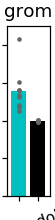

('grom', ('full', 'n_do'), 1.3956341164171775)
('grom', ('full', 'n_o'), 0.9944095247264433)


<IPython.core.display.Javascript object>


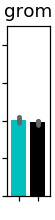

('grom', ('decoder_null', 'n_do'), 1.007708949905273)
('grom', ('decoder_null', 'n_o'), 0.9833668156504327)


<IPython.core.display.Javascript object>


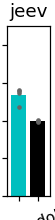

('jeev', ('full', 'n_do'), 1.3366717847696443)
('jeev', ('full', 'n_o'), 0.9924049093426606)


<IPython.core.display.Javascript object>


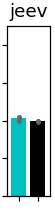

('jeev', ('decoder_null', 'n_do'), 1.0301012460562602)
('jeev', ('decoder_null', 'n_o'), 0.988697828346296)


In [195]:
fig_name = 'lqr_n_diff_bar_shuffle_norm'
save_bool = True

model_pairs_analyze = [model_pairs[1], model_pairs[3]]


figsize=(0.5,2)

x_bar = np.array([0.0,1.0])
bar_width = 0.5
x_margin = (bar_width/2)*2.5
x_lim = copy.copy(x_bar)
x_lim[0] = x_lim[0]-x_margin
x_lim[1] = x_lim[1]+x_margin

color_list = ['c', 'k']

for a in a_list:
    for i_mp, mp in enumerate(model_pairs_analyze):
        plt.figure(figsize=figsize)
        for i_m, m in enumerate(mp):
            
            d_data = s_dic[a,m] #[0:1][np.newaxis,:]
            a_data = s_dic[a,m,'mean']
            x_plt = np.ones(len(d_data))*x_bar[i_m]

            plt_bar = s_dic[a,m,'mean']
            print(a,m,plt_bar)
            plt.bar(x_bar[i_m], plt_bar, width=0.8, color=color_list[i_m])
            plt.plot(x_plt, d_data, '.', color=0.4*np.ones(3), linewidth=0.75, markersize=4)
#                         color=0.4*np.ones(3),zorder=1000)
            
        #plt.hlines(1, xlim[0], xlim[1])
        plt.xticks(x_bar, [mp[0], mp[1]], rotation=20)
        plt.yticks([0,0.5,1.0,1.5,2.0])
        plt.xlim(x_lim)
        plt.ylim([-0.0,2.25])
        plt.ylabel('distance (divided by shuffle mean)')
        #plt.tight_layout()
        plt.title(a)
        if save_bool:
            for ext in ext_list:
                plt.savefig(os.path.join(plot_dir, fig_name+'_'+a+'_'+str(i_mp)+ext))    

In [ ]:
fig_name = 'lqr_pool_u_norm_normalized'
save_bool = False

figsize=(0.5,2)

x_bar = np.array([0.0,1.0])
bar_width = 0.5
x_margin = (bar_width/2)*2.5
x_lim = copy.copy(x_bar)
x_lim[0] = x_lim[0]-x_margin
x_lim[1] = x_lim[1]+x_margin
# print(x_margin)
# print(x_lim)
for pair in pairs_analyze:
    s_dic = pair_s[pair]
    for a in a_list:
        plt.figure(figsize=figsize)
#         plt.subplots(figsize=(3,6))
        for d in range(a2num_days[a]):
            d_plot = s_dic[a, 'norm'][:,d]
            plt.plot(d_plot, '.-', label=d, color=0.4*np.ones(3),linewidth=0.75, markersize=4)
            plt.title(str(pair) + ' ' + a)

        plt_bar = [s_dic[a,'norm','mean'][0], s_dic[a,'norm','mean'][1]]
        plt.bar(x_bar, plt_bar, width=0.8, color=['c', 'k'])

        plt.xlim(x_lim)
        plt.xticks(x_bar, [pair[0], pair[1]])

        plt.ylim([0, 100])
        plt.yticks([0,50,100])


        plt.ylabel('u_norm') 
#         plt.tight_layout()

        if save_bool:
            for ext in ext_list:
                save_path = os.path.join(plot_dir, fig_name+'_'+a+'_'+ pair[0][0] +ext)
                plt.savefig(save_path)  
                print(save_path)

In [49]:
#Calculate how many command-conditions are significantly different 
#for each animal, model
min_obs = 15

save_raw= True

proj = 'null'
p_thr = 0.025

s_dic = {}
for a in a_list:
    num_days = a2num_days[a]
    for m in model_list_analyze:
        s_dic[a,m,'frac_sig'] = []
        for d in range(num_days):
            s_dic[a,m,d] = {}
            s_dic[a,m,d]['pool'] = []
            
            print(a,m,d)
            #Loop command and condition
            for c in c_list:
                for mv in move_list:
                    num_obs = r_pool[a,d]['model_cm'][m,c,mv,'num_obs']
                    #print(a,m,d,c,mv,num_obs)
                    if num_obs >= min_obs:
                        s_dic[a,m,d][c,mv] = {}
                        k = (m,c,mv,'n_diff_norm', 's', proj)
                        if k in r_pool[a,d]['model_cm'].keys():
                            s = r_pool[a,d]['model_cm'][k]
                            obs = r_pool[a,d]['model_cm'][m,c,mv,'n_diff_norm', 'obs', proj]
                            d_cmp = obs > s
                            ng = np.sum(d_cmp)
                            pv = np.float(ng)/num_shuffle
                            s_dic[a,m,d][c,mv]['pv'] = pv
                            s_dic[a,m,d]['pool'].append(pv)

#                             print(obs)
#                             print(s)
#                             print(d_cmp)
#                             print(ng)
#                             print(pv)
#                             raw_input()

                            if save_raw: 
                                s_dic[a,m,d][c,mv]['s', proj] = s
                                s_dic[a,m,d][c,mv]['obs', proj] = obs
            s_dic[a,m,d]['pool'] = np.array(s_dic[a,m,d]['pool'])
            num_pool = len(s_dic[a,m,d]['pool'])
            sig_vec = s_dic[a,m,d]['pool']>=(1-p_thr)
            s_dic[a,m,d]['frac_sig'] = np.sum(sig_vec)/np.float(num_pool)
            s_dic[a,m,'frac_sig'].append(s_dic[a,m,d]['frac_sig'])
        s_dic[a,m,'frac_sig'] = np.array(s_dic[a,m,'frac_sig'])

cm_sig_dic = copy.deepcopy(s_dic)

('grom', ('full', 'n_do'), 0)
('grom', ('full', 'n_do'), 1)
('grom', ('full', 'n_do'), 2)
('grom', ('full', 'n_do'), 3)
('grom', ('full', 'n_do'), 4)
('grom', ('full', 'n_do'), 5)
('grom', ('full', 'n_do'), 6)
('grom', ('full', 'n_do'), 7)
('grom', ('full', 'n_do'), 8)
('grom', ('decoder_null', 'n_do'), 0)
('grom', ('decoder_null', 'n_do'), 1)
('grom', ('decoder_null', 'n_do'), 2)
('grom', ('decoder_null', 'n_do'), 3)
('grom', ('decoder_null', 'n_do'), 4)
('grom', ('decoder_null', 'n_do'), 5)
('grom', ('decoder_null', 'n_do'), 6)
('grom', ('decoder_null', 'n_do'), 7)
('grom', ('decoder_null', 'n_do'), 8)
('grom', ('full', 'n_o'), 0)
('grom', ('full', 'n_o'), 1)
('grom', ('full', 'n_o'), 2)
('grom', ('full', 'n_o'), 3)
('grom', ('full', 'n_o'), 4)
('grom', ('full', 'n_o'), 5)
('grom', ('full', 'n_o'), 6)
('grom', ('full', 'n_o'), 7)
('grom', ('full', 'n_o'), 8)
('grom', ('decoder_null', 'n_o'), 0)
('grom', ('decoder_null', 'n_o'), 1)
('grom', ('decoder_null', 'n_o'), 2)
('grom', ('decod

In [51]:
cm_sig_dic = copy.deepcopy(s_dic)

In [52]:
for a in a_list:
    num_days = a2num_days[a]
    for m in model_list_analyze:
        print(a,m)
        print(cm_sig_dic[a,m,'frac_sig'])

('grom', ('full', 'n_do'))
[0.87378641 0.69152542 0.68253968 0.53225806 0.44954128 0.24367089
 0.52427184 0.38095238 0.50196078]
('grom', ('decoder_null', 'n_do'))
[0.0952381  0.08675799 0.03968254 0.04333333 0.07594937 0.03947368
 0.05263158 0.03303303 0.04347826]
('grom', ('full', 'n_o'))
[0.00420168 0.04054054 0.02307692 0.01712329 0.01877934 0.03985507
 0.02536232 0.028125   0.015     ]
('grom', ('decoder_null', 'n_o'))
[0.02       0.01363636 0.00775194 0.03367003 0.00423729 0.02749141
 0.03308824 0.02906977 0.01980198]
('jeev', ('full', 'n_do'))
[0.46601942 0.41719745 0.40594059 0.24820144]
('jeev', ('decoder_null', 'n_do'))
[0.0609319  0.06666667 0.07317073 0.03272727]
('jeev', ('full', 'n_o'))
[0.01465201 0.0177305  0.02135231 0.01937984]
('jeev', ('decoder_null', 'n_o'))
[0.03900709 0.0174216  0.0035461  0.02919708]


<IPython.core.display.Javascript object>


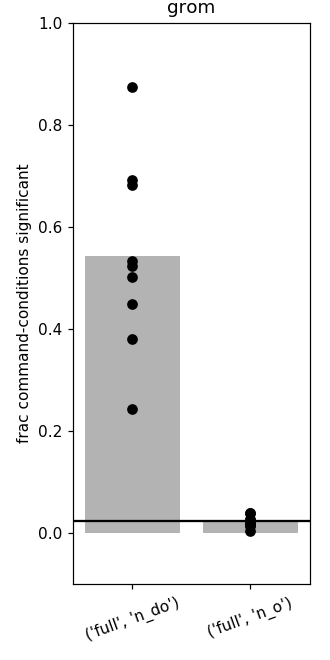

('grom', ('full', 'n_do'), 0.5422785287730594)
('grom', ('full', 'n_o'), 0.0235626851098131)


<IPython.core.display.Javascript object>


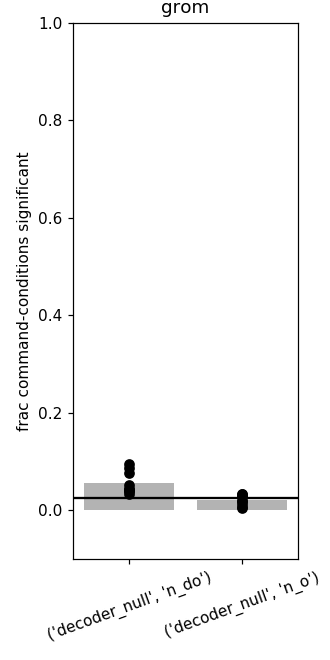

('grom', ('decoder_null', 'n_do'), 0.056619764807849866)
('grom', ('decoder_null', 'n_o'), 0.02097189058835472)


<IPython.core.display.Javascript object>


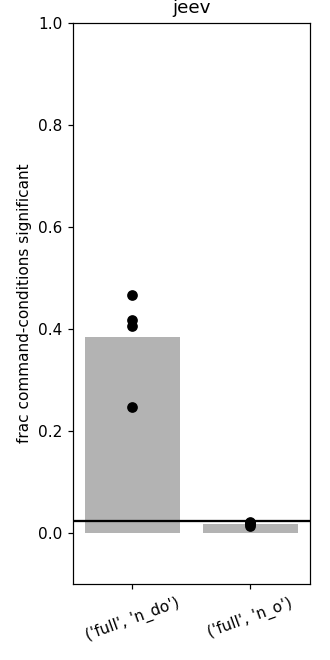

('jeev', ('full', 'n_do'), 0.38433972565333857)
('jeev', ('full', 'n_o'), 0.018278667308603863)


<IPython.core.display.Javascript object>


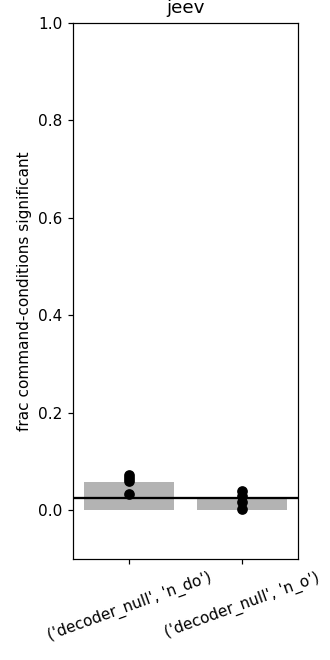

('jeev', ('decoder_null', 'n_do'), 0.05837414268570838)
('jeev', ('decoder_null', 'n_o'), 0.022292968642197236)


In [54]:
fig_name = ''
save_bool = False

model_pairs_analyze = [model_pairs[1], model_pairs[3]]

x_vec = np.array([0,1])
xlim = np.array([-0.5, 1.5])
for a in a_list:
    for mp in model_pairs_analyze:
        plt.figure(figsize=(3,6))
        for i_m, m in enumerate(mp):
            
            d_data = s_dic[a,m,'frac_sig']
            a_data = np.mean(d_data)
            x_plt = np.ones(len(d_data))*x_vec[i_m]

            plt_bar = a_data
            print(a,m,plt_bar)
            plt.bar(x_vec[i_m], plt_bar, width=0.8, color=0.7*np.ones(3))
            plt.scatter(x_plt, d_data, color='k',zorder=1000)
            
        plt.hlines(p_thr, xlim[0], xlim[1])
        plt.xticks(x_vec, [mp[0], mp[1]], rotation=20)        
        plt.xlim(xlim)
        plt.ylim([-0.10,1.0])
        plt.ylabel('frac command-conditions significant')
        plt.tight_layout()
        plt.title(a)
        if save_bool:
            for ext in ext_list:
                plt.savefig(os.path.join(plot_dir, fig_name+'_'+a+'_'+str(i_mp)+ext))    

In [108]:
#Calculate how many commands are significantly different, aggregating over conditions
#for each animal, model
min_obs = 15

save_raw= True

proj = 'null'
p_thr = 0.05

s_dic = {}
for a in a_list:
    num_days = a2num_days[a]
    for m in model_list_analyze: #[model_list_analyze[0]]:
        s_dic[a,m,'frac_sig'] = np.zeros(num_days)
        for d in range(num_days): #[0]
            s_dic[a,m,d] = {}
            s_dic[a,m,d]['sig', 'pool'] = []
            
            print(a,m,d)
            #Loop command and condition
            for c in c_list:
                
                #----------------------------------------
                #aggregate over conditions
                s_dic[a,m,d][c, 'obs', 'pool'] = []
                s_dic[a,m,d][c, 's', 'pool'] = []
                
                num_mv_analyzed = 0
                for mv in move_list:
                    num_obs = r_pool[a,d]['model_cm'][m,c,mv,'num_obs']
                    #print(a,m,d,c,mv,num_obs)
                    if num_obs >= min_obs:
                        s_dic[a,m,d][c,mv] = {}
                        k = (m,c,mv,'n_diff_norm', 's', proj)
                        
                        if k in r_pool[a,d]['model_cm'].keys():
                            num_mv_analyzed += 1
                            
                            s = r_pool[a,d]['model_cm'][k]
                            obs = r_pool[a,d]['model_cm'][m,c,mv,'n_diff_norm', 'obs', proj]
                            
                            s_dic[a,m,d][c, 's', 'pool'].append(s)
                            s_dic[a,m,d][c, 'obs', 'pool'].append(obs)
                #-----------------------------------------
                
                if num_mv_analyzed > 0:             
                    #print(num_mv_analyzed)
                    s_dic[a,m,d][c, 's', 'pool'] = np.vstack(s_dic[a,m,d][c, 's', 'pool'])
                    s_dic[a,m,d][c, 'obs', 'pool'] = np.vstack(s_dic[a,m,d][c, 'obs', 'pool'])
                    
                    #Sum over movements
                    s_dic[a,m,d][c, 's_sum', 'pool'] = np.sum(s_dic[a,m,d][c, 's', 'pool'],axis=0)
                    s_dic[a,m,d][c, 'obs_sum', 'pool'] = np.sum(s_dic[a,m,d][c, 'obs', 'pool'],axis=0)
                    
                    #print(s_dic[a,m,d][c, 's_sum', 'pool'].shape)
                    #print(s_dic[a,m,d][c, 'obs_sum', 'pool'].shape)
                    
                    d_cmp = s_dic[a,m,d][c, 'obs_sum', 'pool'] > s_dic[a,m,d][c, 's_sum', 'pool']
                    ng = np.sum(d_cmp)

                    sig = ng > num_shuffle*(1-p_thr)
                    s_dic[a,m,d]['sig', 'pool'].append(sig)
                
            num_sig = np.sum(s_dic[a,m,d]['sig', 'pool'])
            num_c = np.float(len(s_dic[a,m,d]['sig', 'pool']))
            s_dic[a,m,'frac_sig'][d] = num_sig/num_c


c_sig_dic = copy.deepcopy(s_dic)

('grom', ('full', 'n_do'), 0)
('grom', ('full', 'n_do'), 1)
('grom', ('full', 'n_do'), 2)
('grom', ('full', 'n_do'), 3)
('grom', ('full', 'n_do'), 4)
('grom', ('full', 'n_do'), 5)
('grom', ('full', 'n_do'), 6)
('grom', ('full', 'n_do'), 7)
('grom', ('full', 'n_do'), 8)
('grom', ('decoder_null', 'n_do'), 0)
('grom', ('decoder_null', 'n_do'), 1)
('grom', ('decoder_null', 'n_do'), 2)
('grom', ('decoder_null', 'n_do'), 3)
('grom', ('decoder_null', 'n_do'), 4)
('grom', ('decoder_null', 'n_do'), 5)
('grom', ('decoder_null', 'n_do'), 6)
('grom', ('decoder_null', 'n_do'), 7)
('grom', ('decoder_null', 'n_do'), 8)
('grom', ('full', 'n_o'), 0)
('grom', ('full', 'n_o'), 1)
('grom', ('full', 'n_o'), 2)
('grom', ('full', 'n_o'), 3)
('grom', ('full', 'n_o'), 4)
('grom', ('full', 'n_o'), 5)
('grom', ('full', 'n_o'), 6)
('grom', ('full', 'n_o'), 7)
('grom', ('full', 'n_o'), 8)
('grom', ('decoder_null', 'n_o'), 0)
('grom', ('decoder_null', 'n_o'), 1)
('grom', ('decoder_null', 'n_o'), 2)
('grom', ('decod

<IPython.core.display.Javascript object>


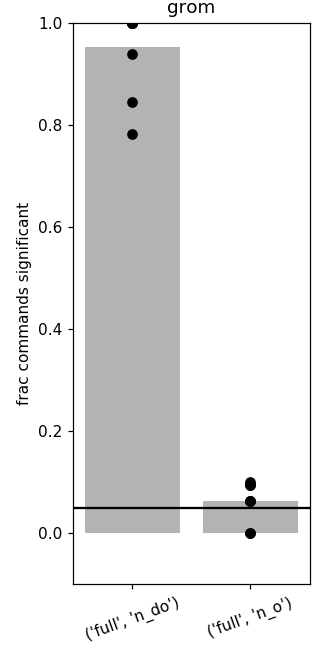

('grom', ('full', 'n_do'), 0.9513888888888888)
('grom', ('full', 'n_o'), 0.06353046594982079)


<IPython.core.display.Javascript object>


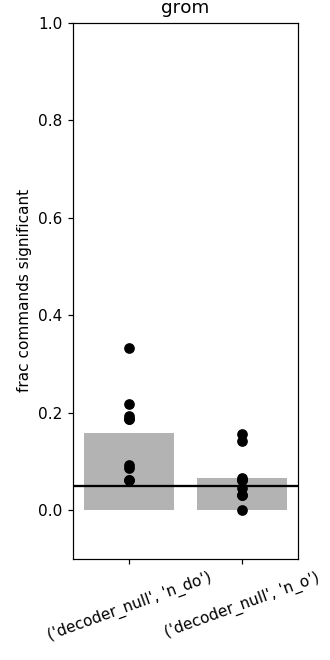

('grom', ('decoder_null', 'n_do'), 0.15848202690769309)
('grom', ('decoder_null', 'n_o'), 0.06652537277537278)


<IPython.core.display.Javascript object>


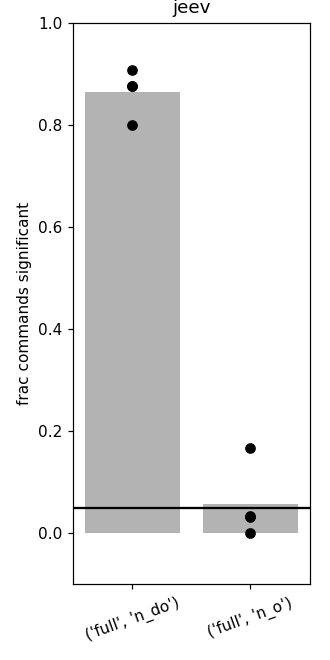

('jeev', ('full', 'n_do'), 0.8640625)
('jeev', ('full', 'n_o'), 0.057812499999999996)


<IPython.core.display.Javascript object>


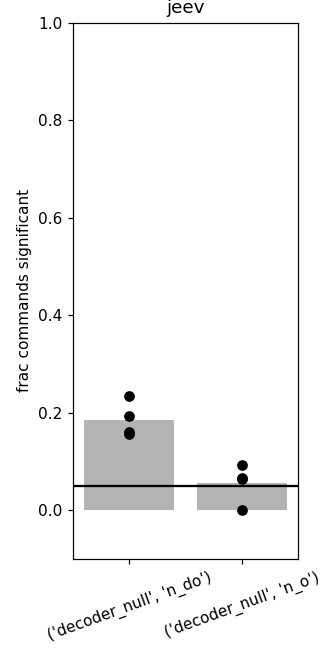

('jeev', ('decoder_null', 'n_do'), 0.18610551075268816)
('jeev', ('decoder_null', 'n_o'), 0.05623319892473118)


In [109]:
fig_name = ''
save_bool = False

model_pairs_analyze = [model_pairs[1], model_pairs[3]]

x_vec = np.array([0,1])
xlim = np.array([-0.5, 1.5])
for a in a_list:
    for mp in model_pairs_analyze:
        plt.figure(figsize=(3,6))
        for i_m, m in enumerate(mp):
            
            d_data = s_dic[a,m,'frac_sig']
            a_data = np.mean(d_data)
            x_plt = np.ones(len(d_data))*x_vec[i_m]

            plt_bar = a_data
            print(a,m,plt_bar)
            plt.bar(x_vec[i_m], plt_bar, width=0.8, color=0.7*np.ones(3))
            plt.scatter(x_plt, d_data, color='k',zorder=1000)
            
        plt.hlines(p_thr, xlim[0], xlim[1])
        plt.xticks(x_vec, [mp[0], mp[1]], rotation=20)        
        plt.xlim(xlim)
        plt.ylim([-0.10,1.0])
        plt.ylabel('frac commands significant')
        plt.tight_layout()
        plt.title(a)
        if save_bool:
            for ext in ext_list:
                plt.savefig(os.path.join(plot_dir, fig_name+'_'+a+'_'+str(i_mp)+ext))    

### Pool N_Diff Bar

In [ ]:
for mv in m_list:
    for c in c_list:
        cm_idx = model_cm[model,c,m,'sel'] 
        print(r_pool[a,d]['model_cm'][m,c,mv,'pool_match_idx'])

In [ ]:
norm_by_shuffle = True

#Loop model pairs

proj = 'null' #'null'#'full'

norm_each_obs = True
zscore = False
data_max = 1e8
min_pool_factor = 2 #10
max_pool_factor = 1e8 #10 #20 #1e8
min_obs = 15 #15
max_obs = 1e8 #50 #50 #1e8 #50

min_std = 0 #1e-7

test_dic = {}
for mp in model_pairs_analyze:
    for i_m, m in enumerate(mp):
        test_dic[mp, i_m] = {'dist':[],'num_obs':[],'pool_factor':[]}

s_dic = {}
for a in a_list:
    for mp in model_pairs_analyze:
        #print(a, mp)
        s_dic[a,mp] = np.zeros((2, a2num_days[a]))
        for i_m, m in enumerate(mp):
            s_dic[a,mp,i_m,'pool'] = []
            
            print(a,m)
            for d in range(a2num_days[a]):
                
                num_obs = np.array(r_pool[a,d]['model_diff'][m, proj]['num_obs'])
                num_pool = np.array(r_pool[a,d]['model_diff'][m, proj]['num_pool'])
                pool_factor_vec = num_pool.astype('float')/num_obs
                #----------------------------------------------------
                pool_sel = (pool_factor_vec >= min_pool_factor) & (pool_factor_vec <= max_pool_factor)
                obs_sel = (num_obs >= min_obs) & (num_obs <= max_obs)
                #----------------------------------------------------
                
                obs_i = np.array(r_pool[a,d]['model_diff'][m, proj]['obs']) #observed distance
            
                s_mean_i =  np.array(r_pool[a,d]['model_diff'][m, proj]['s_mean'])
                s_std_i =  np.array(r_pool[a,d]['model_diff'][m, proj]['s_std'])
                print('obs mean', np.mean(obs_i))
                print('s mean', np.mean(s_mean_i))
                print('s std', np.mean(s_std_i))
                #----------------------------------------------------
                std_sel = s_std_i >= min_std
                #----------------------------------------------------
                
                sel = pool_sel & std_sel & obs_sel
                
                if norm_each_obs:
                    if zscore:
                        z_i = (obs_i[sel]-s_mean_i[sel])/s_std_i[sel]
                    else:
                        z_i = obs_i[sel]/s_mean_i[sel]
                    
                    z_i = z_i[~np.isnan(z_i)]
                    z_i = z_i[~np.isinf(z_i)]
                    #max data: 
                    #z_i[z_i>data_max] = data_max
                    z_i = z_i[z_i<=data_max]
                    print(z_i.shape)
                    print(np.float(z_i.shape[0])/obs_i.shape[0])
                    
                    s_dic[a,mp,i_m,'pool'].append(z_i)
                    z_m = np.mean(z_i)
#                     z_m = np.median(z_i)
                    #print(z_m)
                    s_dic[a,mp][i_m,d] = z_m
                else:
                    if zscore: 
                        z = (np.median(obs_i)-np.median(s_mean_i))/np.median(s_std_i)
                    else:
                        z_m = np.median(obs_i)/np.median(s_mean_i)
                        
                    s_dic[a,mp][i_m,d] = z
                
                #For testing: 
                test_dic[mp, i_m]['dist'].append(z_i)
                test_dic[mp, i_m]['num_obs'].append(num_obs[sel])
                test_dic[mp, i_m]['pool_factor'].append(pool_factor_vec[sel])
                
            s_dic[a,mp,i_m,'pool'] = np.concatenate(s_dic[a,mp,i_m,'pool'])
        s_dic[a,mp,'mean'] = np.mean(s_dic[a,mp],axis=1) #average over sessions

for mp in model_pairs_analyze:
    for i_m, m in enumerate(mp):
        test_dic[mp, i_m]['dist'] = np.concatenate(test_dic[mp, i_m]['dist'])
        test_dic[mp, i_m]['num_obs'] = np.concatenate(test_dic[mp, i_m]['num_obs'])
        test_dic[mp, i_m]['pool_factor'] = np.concatenate(test_dic[mp, i_m]['pool_factor'])

In [ ]:
model_pairs_analyze

In [ ]:
mp = model_pairs_analyze[1]
i_m = 0
for i_m in range(2):
    #print(mp[i_m])
    
    x = test_dic[mp, i_m]['num_obs']
    y = test_dic[mp, i_m]['pool_factor']
    
    plt.figure()
    plt.scatter(x, y, alpha=0.1)
    plt.title(mp[i_m])
    plt.xlabel('num obs (for command-condition)')
    plt.ylabel('pool factor (for command-condition)')
    
    x_mu = np.mean(x)
    y_mu = np.mean(y)
    plt.scatter(x_mu, y_mu, color='r')
    print(x_mu,y_mu)
# plt.hlines(1,0,600)
# plt.vlines(15,0, 110)

In [ ]:
fig_name = 'lqr_pool_n_diff'
save_bool = False

model_pairs_analyze = [model_pairs[1], model_pairs[3]]

if norm_by_shuffle:
    fig_name += '_shuffle_norm'

x_vec = np.array([0,1])
xlim = np.array([-0.5, 1.5])
for a in a_list:
    for i_mp, mp in enumerate(model_pairs_analyze):
        plt.figure(figsize=(3,6))
        for d in range(a2num_days[a]):
            d_plot = s_dic[a,mp][:,d]
            plt.plot(x_vec, d_plot, '.-', label=d, color='k')
            plt.title(a)

    #     x_vec = np.arange(len(model_analyze))
        plt_bar = s_dic[a,mp,'mean']
        plt.bar(x_vec, plt_bar, width=0.8, color=0.7*np.ones(3))

        plt.xticks(x_vec, [mp[0], mp[1]], rotation=20)        
        plt.xlim(xlim)
        if norm_by_shuffle:
            print('norm by shuffle')
            #plt.yticks([0, 0.0025, 0.005, 0.0075, 0.01])
            if a == 'grom':
                #plt.ylim([-2,10])
                plt.ylim([-0.5,2.5])
            elif a == 'jeev':
                #plt.ylim([-2,10])
                plt.ylim([-0.5,2.5])
            plt.ylabel('n_diff (shuffle norm)')
        else:        
#             plt.yticks([0, 0.004, 0.008, 0.012, 0.016])
#             plt.ylim([0, 0.018])
            plt.ylabel('n_diff')

        plt.tight_layout()

        if save_bool:
            for ext in ext_list:
                plt.savefig(os.path.join(plot_dir, fig_name+'_'+a+'_'+str(i_mp)+ext))    

In [ ]:
#want one value per session, and connect them with lines
#one array per session
#save a list with the label: n_do, n_o

s_dic = {}
model_analyze = [('n_do', 'shuffle'), ('n_do', 'total'),('n_o', 'total'), ('n_o', 'shuffle')]
for a in a_list:
    s_dic[a] = np.zeros((len(model_analyze), a2num_days[a]))
    for i_m,m in enumerate(model_analyze):
        for d in range(a2num_days[a]):
            s_dic[a][i_m,d] = np.mean(r_pool[a,d]['r_n'][m])/r_pool[a,d]['num_neurons']
            
    s_dic[a,'mean'] = np.mean(s_dic[a], axis=1)

In [ ]:
fig_name = 'lqr_pool_n_diff_with_shuffle'
save_bool = False

x_vec = np.array([0,1,2.25, 3.25])
xlim = np.array([-0.5, 3.75])
for a in a_list:
    plt.figure(figsize=(3,6))
    for d in range(a2num_days[a]):
        d_plot = s_dic[a][:,d]
        plt.plot(x_vec, d_plot, '.-', label=d, color='k')
        plt.title(a)
    
#     x_vec = np.arange(len(model_analyze))
    plt_bar = s_dic[a,'mean']
    plt.bar(x_vec, plt_bar, width=0.8, color=0.7*np.ones(3))
            
    
    plt.xticks(x_vec, model_analyze, rotation=20)
    plt.xlim(xlim)
    plt.ylabel('n_diff')
    
    if save_bool:
        for ext in ext_list:
            plt.savefig(os.path.join(plot_dir, fig_name+'_'+a+ext))    

In [ ]:
r_pool[a,d]['r_n'][]

In [ ]:
r_pool[a,d]['r_n'][('n_do', 'total')].shape

In [ ]:
r_pool[a,d]['r_n'].keys()

### Pool N_Diff Hist

In [ ]:
model_analyze = [('n_do', 'total'), ('n_do', 'shuffle'),('n_o', 'total'), ('n_o', 'shuffle')]
n_pool_dic = {}
for a in a_list:
    for m in model_analyze:
        n_pool_dic[a, m] = []
        for d in range(a2num_days[a]):
            r_pool[a,d]['r_n'][m]
            n_pool_dic[a, m].append(r_pool[a,d]['r_n'][m])
        n_pool_dic[a, m] = np.concatenate(n_pool_dic[a, m])
        

In [ ]:
#Histogram the diffs and plot overlapping distributions:
#-----------------------------------------------------------------------------------------------------
vmin = 0.0 #-1.5
vmax =  2.5
num_bins = int((vmax-vmin)*30+1)
bins_c = np.linspace(vmin,vmax,num_bins)
bin_w = bins_c[1]-bins_c[0]
bins_e = np.vstack((bins_c-bin_w/2, bins_c+bin_w/2))
bin_dic = {0:bins_e}
bins_e_flat = np.hstack((bins_e[0,:], bins_e[1,-1]))

#-----------------------------------------------------------------------------------------------------
for a in a_list:
    for m in model_analyze:
        data = n_pool_dic[a,m].reshape((-1,1))
        bin_result, hist_result = bmi_b.bin_vec_data(data,bin_dic)
        n_pool_dic[a,m,'hist'] = hist_result
        n_pool_dic[a,m,'bins_e_flat'] = bins_e_flat
        n_pool_dic[a,m,'bins_e'] = bins_e
        n_pool_dic[a,m,'bins_c'] = bins_c

In [ ]:

# a_color = {'grom':'k', 'jeev':'r'}   

color_dic = {('n_do', 'total'): 'r',\
             ('n_do', 'shuffle'): 'k',\
             ('n_o', 'total'): 'b',\
             ('n_o', 'shuffle'): 'g'}

for a in a_list:
    plt.figure(figsize=(6,6))
    for m in model_analyze:
        data =  n_pool_dic[a,m,'hist']
        data_plot = data/np.sum(data)
#         bins_e_flat = n_pool_dic[a,m,'bins_e_flat']
        bmi_util.hist_step_plot(bins_e_flat, data_plot, color=color_dic[m], label=(a,m))
    
    if a=='grom':
        plt.xlim([vmin, 1.5])
    elif a == 'jeev': 
        plt.xlim([vmin, .5])
        
#     plt.vlines(0,0, 0.25, color=np.ones(3)*0.5)
    plt.legend()
    plt.xlabel('n_cm - n_c')
    plt.title(a + ': ' + 'n_cm - n_c, pool over sessions')


### Individual Session U_Norm stats

In [ ]:
#We hypothesize that:
# full: n_do < n_o
# decoder_null: n_do == n_o

In [196]:
model_pairs

[(('full', 'n_do'), ('decoder_null', 'n_do')),
 (('full', 'n_do'), ('full', 'n_o')),
 (('decoder_null', 'n_do'), ('full', 'n_o')),
 (('decoder_null', 'n_do'), ('decoder_null', 'n_o'))]

In [197]:
analyze_pairs = [model_pairs[1], model_pairs[3]]
analyze_pairs

[(('full', 'n_do'), ('full', 'n_o')),
 (('decoder_null', 'n_do'), ('decoder_null', 'n_o'))]

In [199]:
perform_ttest_ind = True
if perform_ttest_ind: 
    for pair in analyze_pairs:
        print(pair)
        for a in a_list:
            for d in range(a2num_days[a]):
                x = r_pool[a,d]['r_u'][pair[0]]
                y = r_pool[a,d]['r_u'][pair[1]]
            
                r_pool[a,d]['r_u'][(pair, 'ttest_ind')] = scipy.stats.ttest_ind(x,y,equal_var=False)
                r_pool[a,d]['r_u'][(pair, 'mannwhitneyu')] = scipy.stats.mannwhitneyu(x,y)
                
                print(a,d)
                print(pair[0])
                print(np.mean(x))

                print(pair[1])
                print(np.mean(y))
                
                #print(r_pool[a,d]['r_u'][(pair, 'ttest_ind')])
                print(r_pool[a,d]['r_u'][(pair, 'mannwhitneyu')])
                print(r_pool[a,d]['r_u'][(pair, 'wilcoxon')])

                print('')

(('full', 'n_do'), ('full', 'n_o'))
('grom', 0)
('full', 'n_do')
7.314522858811704
('full', 'n_o')
11.493197088249227
MannwhitneyuResult(statistic=86.0, pvalue=1.6274340640073745e-05)
WilcoxonResult(statistic=3.0, pvalue=2.669149803181262e-05)

('grom', 1)
('full', 'n_do')
6.5868283846518265
('full', 'n_o')
13.879322103286716
MannwhitneyuResult(statistic=68.0, pvalue=3.005334003865346e-06)
WilcoxonResult(statistic=1.0, pvalue=2.0705605648246455e-05)

('grom', 2)
('full', 'n_do')
1.328814045454077
('full', 'n_o')
1.7439278987364109
MannwhitneyuResult(statistic=156.0, pvalue=0.003349135653238033)
WilcoxonResult(statistic=49.0, pvalue=0.0039052650736518353)

('grom', 3)
('full', 'n_do')
4.923347529913523
('full', 'n_o')
6.9286072654554225
MannwhitneyuResult(statistic=131.0, pvalue=0.0006255306145703872)
WilcoxonResult(statistic=0.0, pvalue=1.821529714896801e-05)

('grom', 4)
('full', 'n_do')
1.2741147582626886
('full', 'n_o')
1.343536207510174
MannwhitneyuResult(statistic=250.0, pvalue=0.

In [221]:
scipy.stats.wilcoxon?

In [ ]:
#Inspect the session stats: 
for pair in analyze_pairs:
    print(pair)
    for a in a_list:
        for d in range(a2num_days[a]):            
            x = r_pool[a,d]['r_u'][pair[0]]
            y = r_pool[a,d]['r_u'][pair[1]]

            print(a,d)
            print(pair[0])
            print(np.mean(x))

            print(pair[1])
            print(np.mean(y))

            print(r_pool[a,d]['r_u'][(pair, 'ttest_ind')])
            print(r_pool[a,d]['r_u'][(pair, 'mannwhitneyu')])
            print(r_pool[a,d]['r_u'][(pair, 'wilcoxon')])
            print('')

In [ ]:
#Inspect the Wilcoxon results for every pair, animal, session
analyze_pairs = [model_pairs[1], model_pairs[3]]
for pair in analyze_pairs:
    pair_test = (pair, 'wilcoxon')
    print(pair)
    for a in a_list:
        for d in range(a2num_days[a]):
            print(a,d)
            print(r_pool[a,d]['r_u'][pair_test])
            
            print(pair[0])
            x = r_pool[a,d]['r_u'][pair[0]]
            print(np.mean(x))
            
            print(pair[1])
            y = r_pool[a,d]['r_u'][pair[1]]
            print(np.mean(y))
            
            print('')

### Pool U_Norm LME

In [ ]:
model_pairs

In [110]:
#Compare neural-activity-distance across pairs in 'model_pairs'
#We will need to loop pairs, and save the results with respect to the pairs

#Pool all data points, group label = session
data = {}
group = {}
model = {}

df_dic = {}
lme_columns = ['data', 'group', 'model']

for a in a_list:
    for pair in model_pairs: #Loop pairs
        data[a] = []
        group[a] = []
        model[a] = []    
        for i_m in range(2): #loop the elements of the pair
            m = pair[i_m]
            for d in range(a2num_days[a]):
                data_i = r_pool[a,d]['r_u'][m]
                group_i = d*np.ones(len(data_i))
                model_i = i_m*np.ones(len(data_i))
                
                data[a].append(data_i)
                group[a].append(group_i)
                model[a].append(model_i)
            
        data[a] = np.concatenate(data[a]).reshape((-1,1))
        group[a] = np.concatenate(group[a]).reshape((-1,1))
        model[a] = np.concatenate(model[a]).reshape((-1,1))

        pre_df = np.concatenate((data[a], group[a], model[a]), axis=1)
        df_lme = pd.DataFrame(data=pre_df, index=range(pre_df.shape[0]), columns=lme_columns)
        md = smf.mixedlm("data ~ C(model)", df_lme, groups=df_lme["group"])
    #     md = smf.mixedlm("data ~ C(model)", df_lme, groups=df_lme["group"])
        mdf = md.fit()
    #     mdf = md.fit(method=["lbfgs"])
        pv = mdf.pvalues
        
        print('')
        print(a, pair)
        print(mdf.summary())
        print(mdf.pvalues)


        #ASSIGN:
        df_dic[a, pair] = df_lme
        df_dic[a, pair, 'mdf'] = mdf
        df_dic[a, pair, 'pv'] = pv


('grom', (('full', 'n_do'), ('decoder_null', 'n_do')))
          Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: data      
No. Observations:  432     Method:             REML      
No. Groups:        9       Scale:              6.5937    
Min. group size:   48      Likelihood:         -1038.0695
Max. group size:   48      Converged:          Yes       
Mean group size:   48.0                                  
---------------------------------------------------------
                Coef. Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept       4.583    1.046  4.380 0.000  2.533  6.634
C(model)[T.1.0] 2.587    0.247 10.469 0.000  2.102  3.071
Group Var       9.580    1.910                           

Intercept          1.185686e-05
C(model)[T.1.0]    1.204320e-25
Group Var          5.073791e-02
dtype: float64

('grom', (('full', 'n_do'), ('full', 'n_o')))
          Mixed Linear Model Regression R

c:\anaconda3\envs\py2\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\anaconda3\envs\py2\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2059: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
c:\anaconda3\envs\py2\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\anaconda3\envs\py2\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2059: ConvergenceWarning: Retrying MixedLM optimization with cg
  ConvergenceWarning)
c:\anaconda3\envs\py2\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\anaconda3\envs\py2\lib\site-packages\sta

### Pool U_Norm Bar

In [ ]:
model_list_analyze

In [ ]:
model_pairs

In [ ]:
r_pool[a,d]['r_u'][model_list_analyze[0]] #.keys()

In [111]:
#Analyze pairs of models: 

pairs_analyze = [model_pairs[1], model_pairs[3]]
pair_s = {} #session data for each model pair
for pair in pairs_analyze:
    pair_s[pair] = {}
    for a in a_list:
        pair_s[pair][a] = np.zeros((2, a2num_days[a])) #2 is hardcoded because we will just compare 2 models
        pair_s[pair][a, 'norm'] = np.zeros((2, a2num_days[a]))
        for i_m in range(2):
            m = pair[i_m]
            for d in range(a2num_days[a]):
                pair_s[pair][a][i_m,d] = np.mean(r_pool[a,d]['r_u'][m])
        pair_s[pair][a,'mean'] = np.mean(pair_s[pair][a], axis=1)
        
        #Normalize by the second model:
        for d in range(a2num_days[a]):
            normalizer = pair_s[pair][a][1,d]
            for i_m in range(2):
                pair_s[pair][a, 'norm'][i_m,d] = 100*pair_s[pair][a][i_m,d]/normalizer
        pair_s[pair][a,'norm','mean'] = np.mean(pair_s[pair][a,'norm'], axis=1)
    

In [ ]:
#Inspect: 

In [ ]:
pair_s[pairs_analyze[0]]['grom','norm','mean']

In [ ]:
pair_s[pairs_analyze[1]]['grom','norm','mean']

In [ ]:
pair_s[pairs_analyze[0]]['jeev','norm','mean']

In [ ]:
pair_s[pairs_analyze[1]]['jeev','norm','mean']

In [ ]:
pair

In [ ]:
str(pair)

In [ ]:
plot_dir

<IPython.core.display.Javascript object>


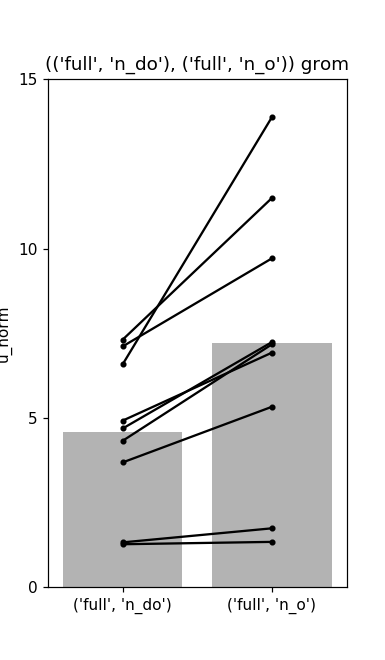

<IPython.core.display.Javascript object>


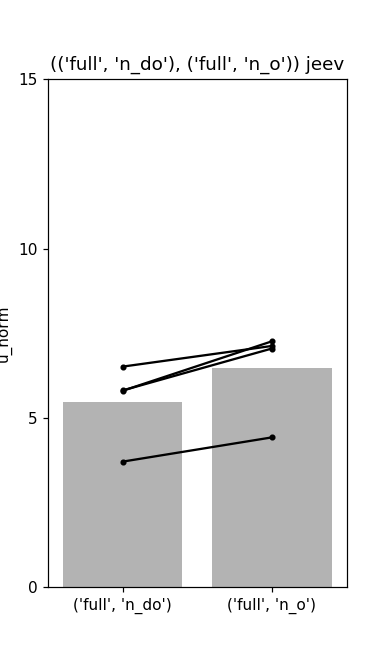

<IPython.core.display.Javascript object>


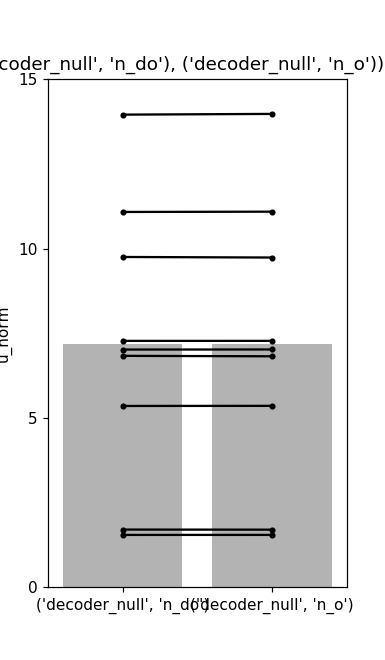

<IPython.core.display.Javascript object>


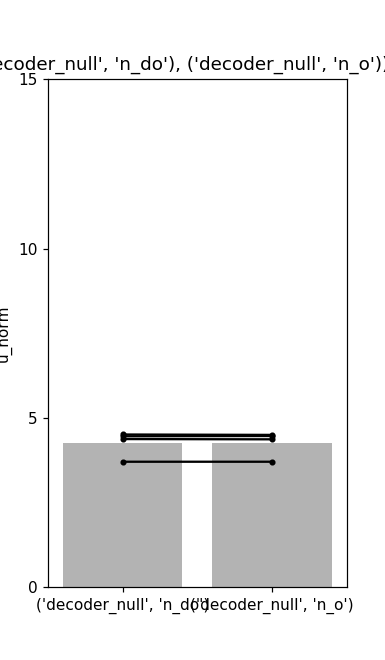

In [112]:
fig_name = 'lqr_pool_u_norm'
save_bool = False

for pair in pairs_analyze:
    s_dic = pair_s[pair]
    for a in a_list:
        plt.figure(figsize=(3.5,6))
#         plt.subplots(figsize=(3,6))
        for d in range(a2num_days[a]):
            d_plot = s_dic[a][:,d]
            plt.plot(d_plot, '.-', label=d, color='k')
            plt.title(str(pair) + ' ' + a)

        plt_bar = [s_dic[a,'mean'][0], s_dic[a,'mean'][1]]
        plt.bar([0,1], plt_bar, width=0.8, color=0.7*np.ones(3))

        plt.xlim([-0.5, 1.5])
        plt.xticks([0,1], [pair[0], pair[1]])

        plt.ylim([0, 15])
        plt.yticks([0,5,10,15])


        plt.ylabel('u_norm') 
#         plt.tight_layout()

        if save_bool:
            for ext in ext_list:
                save_path = os.path.join(plot_dir, fig_name+'_'+a+'_'+ pair[0][0] +ext)
                plt.savefig(save_path)  
                print(save_path)

In [124]:
plot_dir

'D:\\Dropbox\\BMI_co_obs_paper\\data\\vivek\\lqr'

In [125]:
ext_list

['.png', '.eps']

In [133]:
x_lim

array([0, 1])

In [134]:
x_margin

0.5

In [135]:
x_lim[0] -= x_margin

In [137]:
x_lim[0]

0

In [136]:
x_lim

array([0, 1])

<IPython.core.display.Javascript object>


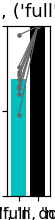

D:\Dropbox\BMI_co_obs_paper\data\vivek\lqr\lqr_pool_u_norm_normalized_grom_full.png
D:\Dropbox\BMI_co_obs_paper\data\vivek\lqr\lqr_pool_u_norm_normalized_grom_full.eps


<IPython.core.display.Javascript object>


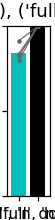

D:\Dropbox\BMI_co_obs_paper\data\vivek\lqr\lqr_pool_u_norm_normalized_jeev_full.png
D:\Dropbox\BMI_co_obs_paper\data\vivek\lqr\lqr_pool_u_norm_normalized_jeev_full.eps


<IPython.core.display.Javascript object>


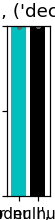

D:\Dropbox\BMI_co_obs_paper\data\vivek\lqr\lqr_pool_u_norm_normalized_grom_decoder_null.png
D:\Dropbox\BMI_co_obs_paper\data\vivek\lqr\lqr_pool_u_norm_normalized_grom_decoder_null.eps


<IPython.core.display.Javascript object>


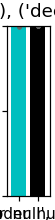

D:\Dropbox\BMI_co_obs_paper\data\vivek\lqr\lqr_pool_u_norm_normalized_jeev_decoder_null.png
D:\Dropbox\BMI_co_obs_paper\data\vivek\lqr\lqr_pool_u_norm_normalized_jeev_decoder_null.eps


In [180]:
fig_name = 'lqr_pool_u_norm_normalized'
save_bool = False

figsize=(0.5,2)

x_bar = np.array([0.0,1.0])
bar_width = 0.5
x_margin = (bar_width/2)*2.5
x_lim = copy.copy(x_bar)
x_lim[0] = x_lim[0]-x_margin
x_lim[1] = x_lim[1]+x_margin
# print(x_margin)
# print(x_lim)
for pair in pairs_analyze:
    s_dic = pair_s[pair]
    for a in a_list:
        plt.figure(figsize=figsize)
#         plt.subplots(figsize=(3,6))
        for d in range(a2num_days[a]):
            d_plot = s_dic[a, 'norm'][:,d]
            plt.plot(d_plot, '.-', label=d, color=0.4*np.ones(3),linewidth=0.75, markersize=4)
            plt.title(str(pair) + ' ' + a)

        plt_bar = [s_dic[a,'norm','mean'][0], s_dic[a,'norm','mean'][1]]
        plt.bar(x_bar, plt_bar, width=0.8, color=['c', 'k'])

        plt.xlim(x_lim)
        plt.xticks(x_bar, [pair[0], pair[1]])

        plt.ylim([0, 100])
        plt.yticks([0,50,100])


        plt.ylabel('u_norm') 
#         plt.tight_layout()

        if save_bool:
            for ext in ext_list:
                save_path = os.path.join(plot_dir, fig_name+'_'+a+'_'+ pair[0][0] +ext)
                plt.savefig(save_path)  
                print(save_path)

In [ ]:
fig_name = 'lqr_pool_u_norm_normalized_trunc'
save_bool = True
#one bar for each animal
x_plt = range(len(a_list))
for pair in pairs_analyze:
    s_dic = pair_s[pair]
    plt.figure(figsize=(4.5,6))
    
    for i_a, a in enumerate(a_list):
        y = s_dic[a, 'norm'][0,:]
        y_mean = s_dic[a,'norm','mean'][0]
        
        plt.plot(i_a*np.ones_like(y), y, '.', label=a, color='k')
        plt.bar(i_a, y_mean, width=0.8, color=0.7*np.ones(3))
            
    plt.title(pair[0][0])
    plt.xlim([-0.5, 1.5])
    plt.xticks(x_plt, a_list)

    plt.ylim([0, 125])
    plt.yticks([0,50,100])

    plt.ylabel('Input Magnitude (Percentage of No Dynamics Model)') 
#         plt.tight_layout()

    if save_bool:
        for ext in ext_list:
            save_path = os.path.join(plot_dir, fig_name+'_'+ pair[0][0] +ext)
            plt.savefig(save_path)  
            print(save_path)

In [ ]:
plot_dir

### Pool U_Norm Hist

In [ ]:
#Make the pooled 
u_pool_dic = {'grom':[], 'jeev':[]}
for a in a_list:
    for d in range(a2num_days[a]):
        r_do = r_pool[a,d]['r_u']['n_do']
        r_o = r_pool[a,d]['r_u']['n_o']
        
        u_diff = np.array(r_do) - np.array(r_o)
        u_pool_dic[a].append(u_diff)
    u_pool_dic[a] = np.concatenate(u_pool_dic[a])

In [ ]:
#Histogram the diffs and plot overlapping distributions:
vmin = -15.0 #-1.5
vmax =  2.0
num_bins = int((vmax-vmin)*2+1)
bins_c = np.linspace(vmin,vmax,num_bins)
bin_w = bins_c[1]-bins_c[0]
bins_e = np.vstack((bins_c-bin_w/2, bins_c+bin_w/2))
bin_dic = {0:bins_e}
bins_e_flat = np.hstack((bins_e[0,:], bins_e[1,-1]))

binned = {}
for a in a_list: 
    data = u_pool_dic[a].reshape((-1,1))
    print(data.shape)
    bin_result, hist_result = bmi_b.bin_vec_data(data,bin_dic)
    binned[a] = hist_result

plt.figure(figsize=(6,6))
a_color = {'grom':'k', 'jeev':'r'}    
for a in a_list:
    data =  binned[a]
    data_plot = data/np.sum(data)
#     d_plot = np.cumsum(d_plot)
    bmi_util.hist_step_plot(bins_e_flat, data_plot,color=a_color[a], label=a)    

plt.xlim([-15, 5])
plt.vlines(0,0, 0.25, color=np.ones(3)*0.5)
plt.legend()
plt.xlabel('u norm diff: n_do - n_o')
plt.title('u norm difference between n_do and n_o, pool over sessions')


### Inspect if all individual sessions are appropriately significant

In [ ]:
#U Norm
print('u norm results:')
for a in a_list: 
    for d in range(a2num_days[a]):
        print(a,d)
        print(r_pool[a, d]['r_u']['wilcoxon'][1])

In [ ]:
#N Diff
print('n diff norm results:')
for a in a_list: 
    for d in range(a2num_days[a]):
        print(a,d)
        print(r_pool[a,d]['r_n']['model_pair_ks'][1])

In [ ]:
#n_do vs shuffle
for a in a_list: 
    for d in range(a2num_days[a]):
        print('n_do vs shuffle:')
        print(r_pool[a,d]['r_n'][('n_do', 'model_shuffle_ks')][1])
          

In [ ]:
#n_do vs shuffle
for a in a_list: 
    for d in range(a2num_days[a]):
        print('n_o vs shuffle:')
        print(r_pool[a,d]['r_n'][('n_o', 'model_shuffle_ks')][1]) 


In [ ]:
r_pool[a,d]['r_n'][('n_do', 'model_shuffle_ks')]

In [ ]:
#Implement LME

### Inspect some results:

In [ ]:
model_pair = ['n_do', 'n_o']
r_u = analyze_u_norm(norm_u_df_n, model_pair, target_list, task_rot_list)

In [ ]:
r_u.keys()

In [ ]:
#Compute p-val for individual session
#Load for the pooled p-val

In [ ]:
model_list

In [ ]:
load_file = 'lqr_sim_20trials.pkl'

# a= 'grom'
a= 'grom'
d = 4
load_dir = os.path.join(save_home, a, str(d))
load_path = os.path.join(load_dir, load_file)
# os.path.exists(load_path)
with open(load_path, 'rb') as f: 
    r = pickle.load(f)
for (k,v) in r.items():
    exec(k+'=v')
    
plot_norm_u(norm_u_df_n, ['n_do', 'n_o'], target_list, task_rot_list)  

In [ ]:
plot_norm_u(norm_u_df_n, ['n_d', 'n_null'], target_list, task_rot_list)  

In [ ]:
plot_norm_u(norm_u_df_n, ['n_do', 'n_null'], target_list, task_rot_list)  

In [ ]:
m_list, c_list, n_list = def_var_lists(num_targets, task_rot_list, num_mag_bins_analyze, num_angle_bins, num_neurons)

In [ ]:
model_cm = compute_command_sel(df_lqr_n, model_list, m_list, c_list)

In [ ]:
p_sig = 0.05
model_cm = match_pool_activity_to_command_movement(model_cm, df_lqr_n, model_list, c_list, m_list, p_sig)

In [ ]:
num_shuffle = 100
model_cm = def_shuffle_mat(model_cm, model_list, c_list, m_list, num_shuffle)

In [ ]:
model_cm_backup = copy.deepcopy(model_cm)

In [ ]:
shuffle_bool = True
model_cm = compute_neural_command_diff(model_cm, df_lqr_n, model_list, m_list, c_list, n_list, shuffle_bool, num_shuffle)

In [ ]:
min_obs = 15
model_diff = collect_neural_command_diff(model_cm, model_list, c_list, m_list, min_obs, shuffle_bool)

In [ ]:
# For debugging: 
model_pair = ['n_do', 'n_o']
model_color = {'n_do':'g', 'n_o':'k'}
diff_list = ['total', 'shuffle']

for diff_sel in diff_list:
    plt.figure(figsize=(5,5))
    for i,m in enumerate(model_pair):
        diff_i = np.array(model_diff[m][diff_sel])
        diff_mean_i = np.mean(diff_i)

        plt.scatter(i*np.ones(len(diff_i)), diff_i, alpha=0.3,color=model_color[m])
        plt.hlines(diff_mean_i, i-0.25,i+0.25)    

    _=plt.xticks([0,1], model_pair)
    plt.title(diff_sel+':'+' command-movement mean minus command mean')
    plt.ylabel('norm difference of activity')

In [ ]:
def analyze_n_diff(model_diff):
    r_n = {}
    #1. compare models
    model_pair = ['n_do', 'n_o']
    for m in model_pair:
        r_n[m, 'total'] = np.array(model_diff[m]['total'])
    r_n['model_pair_ks'] = scipy.stats.ks_2samp(np.array(r_n['n_do', 'total']), np.array(r_n['n_o', 'total']))
#     r_n['model_ks'] = scipy.stats.ks_2samp(np.array(r_n['n_do', 'total']), np.array(r_n['n_o', 'total']))
    
    #2. compare model to its own shuffle
    for m in model_pair:
        m_i = r_n[m,'total']
        s_i = np.array(model_diff[m]['shuffle'])
        r_n[m, 'shuffle'] = s_i
        r_n[m, 'model_shuffle_ks'] = scipy.stats.ks_2samp(m_i, s_i)
#         r_n['model_ks'] = scipy.stats.ks_2samp(m_i, s_i, alternative='greater')
    return r_n

In [ ]:
def analyze_u_norm(df, model_pair, target_list, task_rot_list):
    r_u = {}
    for m in model_list:
        r_u[m]=[]
        
    for target in range(num_targets):
        for task in task_rot_list:
            for i,m in enumerate(model_pair):
                sel = \
                (df['target']==target)\
                &(df['task']==task)\
                &(df['model']==m)
                y_i = float(df.loc[sel,'norm_u'])
                r_u[m].append(y_i)  
    #Stats: 
    r_wilcoxon = scipy.stats.wilcoxon(r_u[model_pair[0]], r_u[model_pair[1]])
    r_u['wilcoxon'] = r_wilcoxon
    return r_u

In [ ]:
def def_var_lists(num_targets, task_rot_list, num_mag_bins_analyze, num_angle_bins, num_neurons):
    #Useful especially when splitting an obstacle movement into cw vs ccw.
    move_list = []
    for target in range(num_targets):
        for task in task_rot_list:
            move_list.append((target,task))
    m_list = move_list #In case we prefer 
    num_move = len(m_list)        
    #List of commands in case it's useful    
    c_list = [] #(bm,ba)
    for bm in range(num_mag_bins_analyze):
        for ba in range(num_angle_bins):
            c_list.append((bm,ba))        
    num_c = len(c_list)
    #List of neurons:
    n_list = ['n_'+str(i) for i in range(num_neurons)]
    
    return m_list, c_list, n_list

In [ ]:
def compute_command_sel(df, model_list, m_list, c_list):
    #Collect the selection 
    t_start = timeit.default_timer()
    model_cm = {} #model,command,movement data
    #key: model,command | model,command,movement
    # for each model: 
    # make an xarray data array for each command-movement and for the command
    # variables should be all the columns of the df
    for model in model_list: #model
        sel_model = (df['model'] == model)
        for ic, c in enumerate(c_list): #command
            bm = c[0]
            ba = c[1]
            sel_ba = (df.loc[:,'u_v_angle_bin']==ba)
            sel_bm = (df.loc[:,'u_v_mag_bin']==bm) 
            sel_c = sel_model&sel_ba&sel_bm   
            model_cm[model,c,'sel'] = sel_c
            model_cm[model,c,'num_obs'] = sum(sel_c)
            for im, m in enumerate(m_list): #movement
                print(model, c, m)
                target = m[0]
                task = m[1]
                sel_m = (df.loc[:,'target']==target)&(df.loc[:,'task_rot']==task)
                sel_cm = sel_c&sel_m
                model_cm[model,c,m,'sel'] = sel_cm
                model_cm[model,c,m,'num_obs'] = sum(sel_cm)
    t_elapsed = timeit.default_timer()-t_start
    print(t_elapsed)
    return model_cm

In [ ]:
def match_pool_activity_to_command_movement(model_cm, df, model_list, c_list, m_list, p_sig):
    #---------------------------------------------------------------------------------------------------------------------
    t_start = timeit.default_timer()
    #key: model,command | model,command,movement
    # for each model: 
    # make an xarray data array for each command-movement and for the command
    # variables should be all the columns of the df
    var = ['u_vx', 'u_vy']
    match_var = var
    for model in model_list: #model
        for ic, c in enumerate(c_list): #command    
            sel_c = model_cm[model,c,'sel']
            c_idx = df[sel_c].index.values
            c_da = bmi_b.df_idx2da(df,c_idx,var)

            for im, m in enumerate(m_list): #movement
                #data array of var of interest
                print(model, c, m)
                sel_cm = model_cm[model,c,m,'sel']
                cm_idx = df[sel_cm].index.values
                cm_da = bmi_b.df_idx2da(df,cm_idx,var)

                success, kept_list, discard_list, df_match, ttest_r, mean_r = \
                        bmi_b.subsample_dataset_to_match_mean_target_dataset(match_var, d_ss=c_da, d_target=cm_da, p_sig=p_sig, frac_data_exclude_per_iter=0.05, min_frac_remain=0.1)            
                model_cm[model,c,m,'pool_match_idx'] = kept_list[0]
                model_cm[model,c,m,'pool_match_success'] = success
                model_cm[model,c,m,'pool_match_discard'] = discard_list[0]
                model_cm[model,c,m,'pool_match_ttest'] = ttest_r
                model_cm[model,c,m,'pool_match_mean'] = mean_r                    
    t_elapsed = timeit.default_timer()-t_start 
    print(t_elapsed)
    return model_cm

In [ ]:
def def_shuffle_mat(model_cm, model_list, c_list, m_list, num_shuffle):
    #---------------------------------------------------------------------------------------------------------------------
    #make a shuffle mat for each command.
    #shuffle mat contains the idxs chosen for each shuffle 
    #For each movement, pick K samples at random from the 'movement-pooled'
    t_start = timeit.default_timer()
    for model in model_list:
        for c in c_list:
            for m in m_list:
                c_idxs = model_cm[model,c,m,'pool_match_idx']
                num_obs = model_cm[model,c,m,'num_obs']
                shuffle_mat = np.ones((num_obs, num_shuffle))*np.nan

                if len(c_idxs)<num_obs:
                    for s in range(num_shuffle):
                        shuffle_mat[:,s] = np.random.choice(c_idxs,num_obs,replace=True)                
                else:
                    for s in range(num_shuffle):
                        shuffle_mat[:,s] = np.random.choice(c_idxs,num_obs,replace=False)
                #ASSIGN:
                model_cm[model,c,m,'shuffle_mat'] = shuffle_mat
    t_elapsed = timeit.default_timer()-t_start       
    print(t_elapsed)
    return model_cm

In [ ]:
def compute_neural_command_diff(model_cm, df, model_list, m_list, c_list, n_list, shuffle_bool, num_shuffle):
    #---------------------------------------------------------------------------------------------------------------------
    t_start = timeit.default_timer()
    n_df = np.array(df[n_list])

    mean_var = copy.copy(n_list)
    for model in model_list: #model
        for ic, c in enumerate(c_list): #command    
            for im, m in enumerate(m_list): #movement

                if model_cm[model,c,m,'pool_match_success']:    
                    print(model,c,m)
                    c_idxs = model_cm[model,c,m,'pool_match_idx']#use these idxs for average
    #                 mu_c = df.loc[c_idxs, mean_var].mean()
                    mu_c = n_df[c_idxs, :].mean(axis=0) 

                    #MOVE:
                    cm_sel = model_cm[model,c,m,'sel']
                    cm_idxs = cm_sel[cm_sel].index.values
    #                 mu_cm = df.loc[cm_idxs, mean_var].mean()       
                    mu_cm = n_df[cm_idxs, :].mean(axis=0) 

                    if shuffle_bool: 
                        #SHUFFLE:
                        nan_mat = np.ones((len(mean_var), num_shuffle))*np.nan
                        s_mean = xr.DataArray(nan_mat, 
                                          coords={'v':mean_var,'shuffle':range(num_shuffle)},
                                          dims=['v','shuffle'])
                        for s in range(num_shuffle):
                            s_idxs = model_cm[model,c,m,'shuffle_mat'][:,s].astype(int)
    #                         mu_s = df.loc[s_idxs, mean_var].mean()
                            mu_s = n_df[s_idxs, :].mean(axis=0)
                            s_mean.loc[:,s] = mu_s

                    #DIFFERENCE: 

                    #ASSIGN:
    #                 model_cm[model,c,m,'mat_df'] = df.loc[cm_idxs, mean_var]
                    model_cm[model,c,m,'n_c'] = mu_c
                    model_cm[model,c,m,'n_cm'] = mu_cm

                    diff_i = mu_c-mu_cm   
                    diff_potent_i, diff_null_i, _ = bmi_util.proj_null_potent(Kn[2:4,:].T, np.array(diff_i).reshape((-1,1)))
                    model_cm[model,c,m,'n_diff_true'] = diff_i             
                    model_cm[model,c,m,'n_diff_norm_true'] = np.linalg.norm(diff_i)
                    model_cm[model,c,m,'n_diff_norm_potent'] = np.linalg.norm(diff_potent_i)
                    model_cm[model,c,m,'n_diff_norm_null'] = np.linalg.norm(diff_null_i)

                    if shuffle_bool: 
                        model_cm[model,c,m,'n_s'] = s_mean              
                        n_c_rep = np.array(mu_c)[...,None]
                        model_cm[model,c,m,'n_diff_s'] = n_c_rep-s_mean
                        model_cm[model,c,m,'n_diff_s_norm'] = np.linalg.norm(model_cm[model,c,m,'n_diff_s'], axis=0)
                        model_cm[model,c,m,'n_diff_s_norm_mean'] = model_cm[model,c,m,'n_diff_s_norm'].mean()

    t_elapsed = timeit.default_timer()-t_start
    print(t_elapsed)
    
    return model_cm

In [ ]:
def main_compute_neural_command_diff(df, model_list, m_list, c_list, n_list, p_sig_match, shuffle_bool, num_shuffle):
    model_cm = compute_command_sel(df, model_list, m_list, c_list)
    model_cm = match_pool_activity_to_command_movement(model_cm, df, model_list, c_list, m_list, p_sig=p_sig_match)
    model_cm = def_shuffle_mat(model_cm, model_list, c_list, m_list, num_shuffle)
    model_cm = compute_neural_command_diff(model_cm, df, model_list, m_list, c_list, n_list, shuffle_bool, num_shuffle)

    return model_cm

In [ ]:
def collect_neural_command_diff(model_cm, model_list, c_list, m_list, min_obs, shuffle_bool):
    #---------------------------------------------------------------------------------------------------------------------
    #loop over all conditions, collect a list of differences:
    
    model_diff = {}
    for model in model_list: #model
        model_diff[model] = {'total':[], 'potent':[],'null':[], 'shuffle':[]}
        for ic, c in enumerate(c_list): #command    
            for im, m in enumerate(m_list): #movement
                if model_cm[model,c,m,'pool_match_success']:  
                    #project the diff

                    diff_i = model_cm[model,c,m,'n_diff_true']

                    if model_cm[model,c,m,'num_obs'] > min_obs:
                        if not np.isnan(diff_i).any():
                            diff_potent_i, diff_null_i, _ = bmi_util.proj_null_potent(Kn[2:4,:].T, np.array(diff_i).reshape((-1,1)))
                            norm_potent_i = np.linalg.norm(diff_potent_i)
                            norm_null_i = np.linalg.norm(diff_null_i)

                            model_diff[model]['total'].append(model_cm[model,c,m,'n_diff_norm_true'])
                            model_diff[model]['potent'].append(norm_potent_i)
                            model_diff[model]['null'].append(norm_null_i)

                            if shuffle_bool: 
                                model_diff[model]['shuffle'].append(model_cm[model,c,m,'n_diff_s_norm_mean']) 
    return model_diff

In [ ]:
def plot_norm_u(norm_u_df, model_list, target_list, task_rot_list):
    #Plot norm u for all movements: 
    # model_list = ['n_do', 'n_o', 'n_null']
#     model_list = ['n_do', 'n_null']
    task_alpha = {0:1, 1.1:0.5, 1.2:0.5}
    plt.figure(figsize=(3,6))
    for target in target_list:
        for task in task_rot_list:

            x_plot = []
            y_plot = []
            for i,m in enumerate(model_list):
                x_plot.append(i)
                sel = \
                (norm_u_df['target']==target)\
                &(norm_u_df['task']==task)\
                &(norm_u_df['model']==m)
                y_i = float(norm_u_df.loc[sel,'norm_u'])
                y_plot.append(y_i)

            plt.plot(x_plot,y_plot,color=target_color[target], alpha=task_alpha[task]) #label='target'+str(target)+'task'+str(task)

    plt.xticks(range(len(model_list)), model_list)
    plt.ylabel('norm u')
    plt.title('norm u')
    plt.xlim(np.array([0, len(model_list)])-0.5)   

In [ ]:
#Let's check the norm_u: 
#BAD: 
#monkey g: 
#2, 

#MEH:
#monkey g:
#4, 